In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [5]:
path = Path('./data')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64'
}
store_sales = pd.read_csv(
    path/'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype=dtype,
    parse_dates=['date']
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train.csv'

In [3]:
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
avg_sales = store_sales.groupby('date')['sales'].mean()

In [218]:
avg_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

In [5]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [24]:
df = avg_sales.to_frame()
df['time'] = np.arange(len(avg_sales))
df['lag_1'] = avg_sales.shift(1)
df.fillna(0, inplace=True)
df.head()

sales  time       lag_1
date                                    
2013-01-01    1.409438     0    0.000000
2013-01-02  278.390808     1    1.409438
2013-01-03  202.840195     2  278.390808
2013-01-04  198.911163     3  202.840195
2013-01-05  267.873260     4  198.911163

## Time dependence

### Time dummy

Text(0.5, 1.0, 'Time Plot of Total Sales')

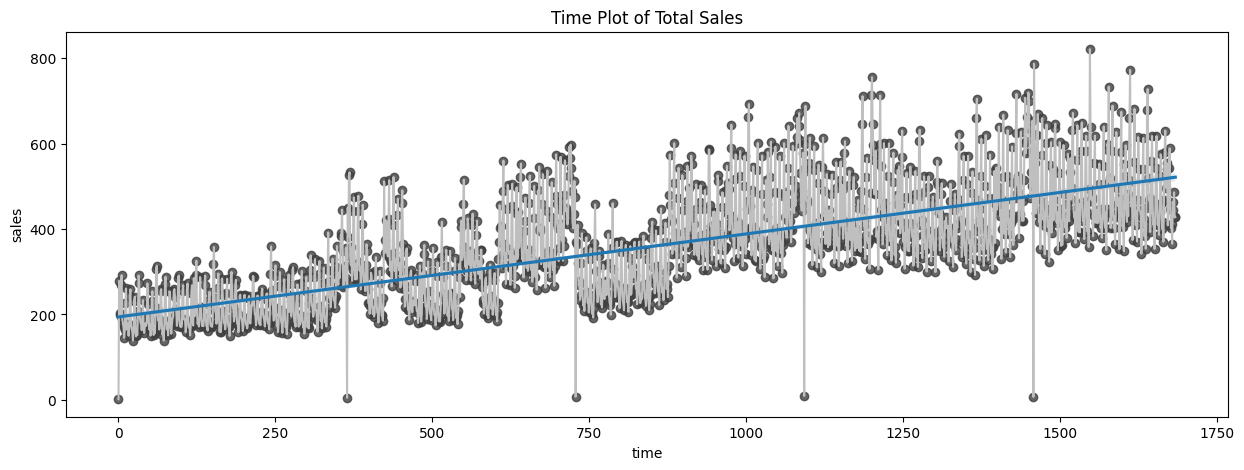

In [25]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot('time','sales',data=df,color='0.75')
ax = sns.regplot(x='time',y='sales',data=df,scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Total Sales')

Text(0.5, 1.0, 'Lag Plot of Total Sales')

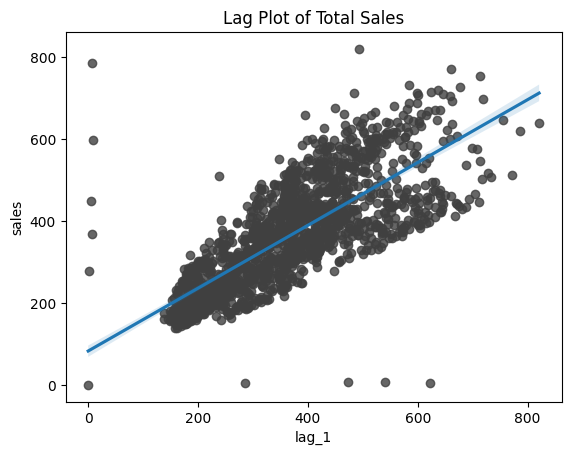

In [18]:
ax.plot('lag_1','sales',data=df)
ax = sns.regplot(x='lag_1', y='sales', data=df, scatter_kws=dict(color='0.25'))
ax.set_title('Lag Plot of Total Sales')

In [16]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [30]:
moving_avg = avg_sales.rolling(
    window=365,
    center=True,
    min_periods=183
).mean()

Text(0.5, 1.0, '365-Day Moving Average Sales')

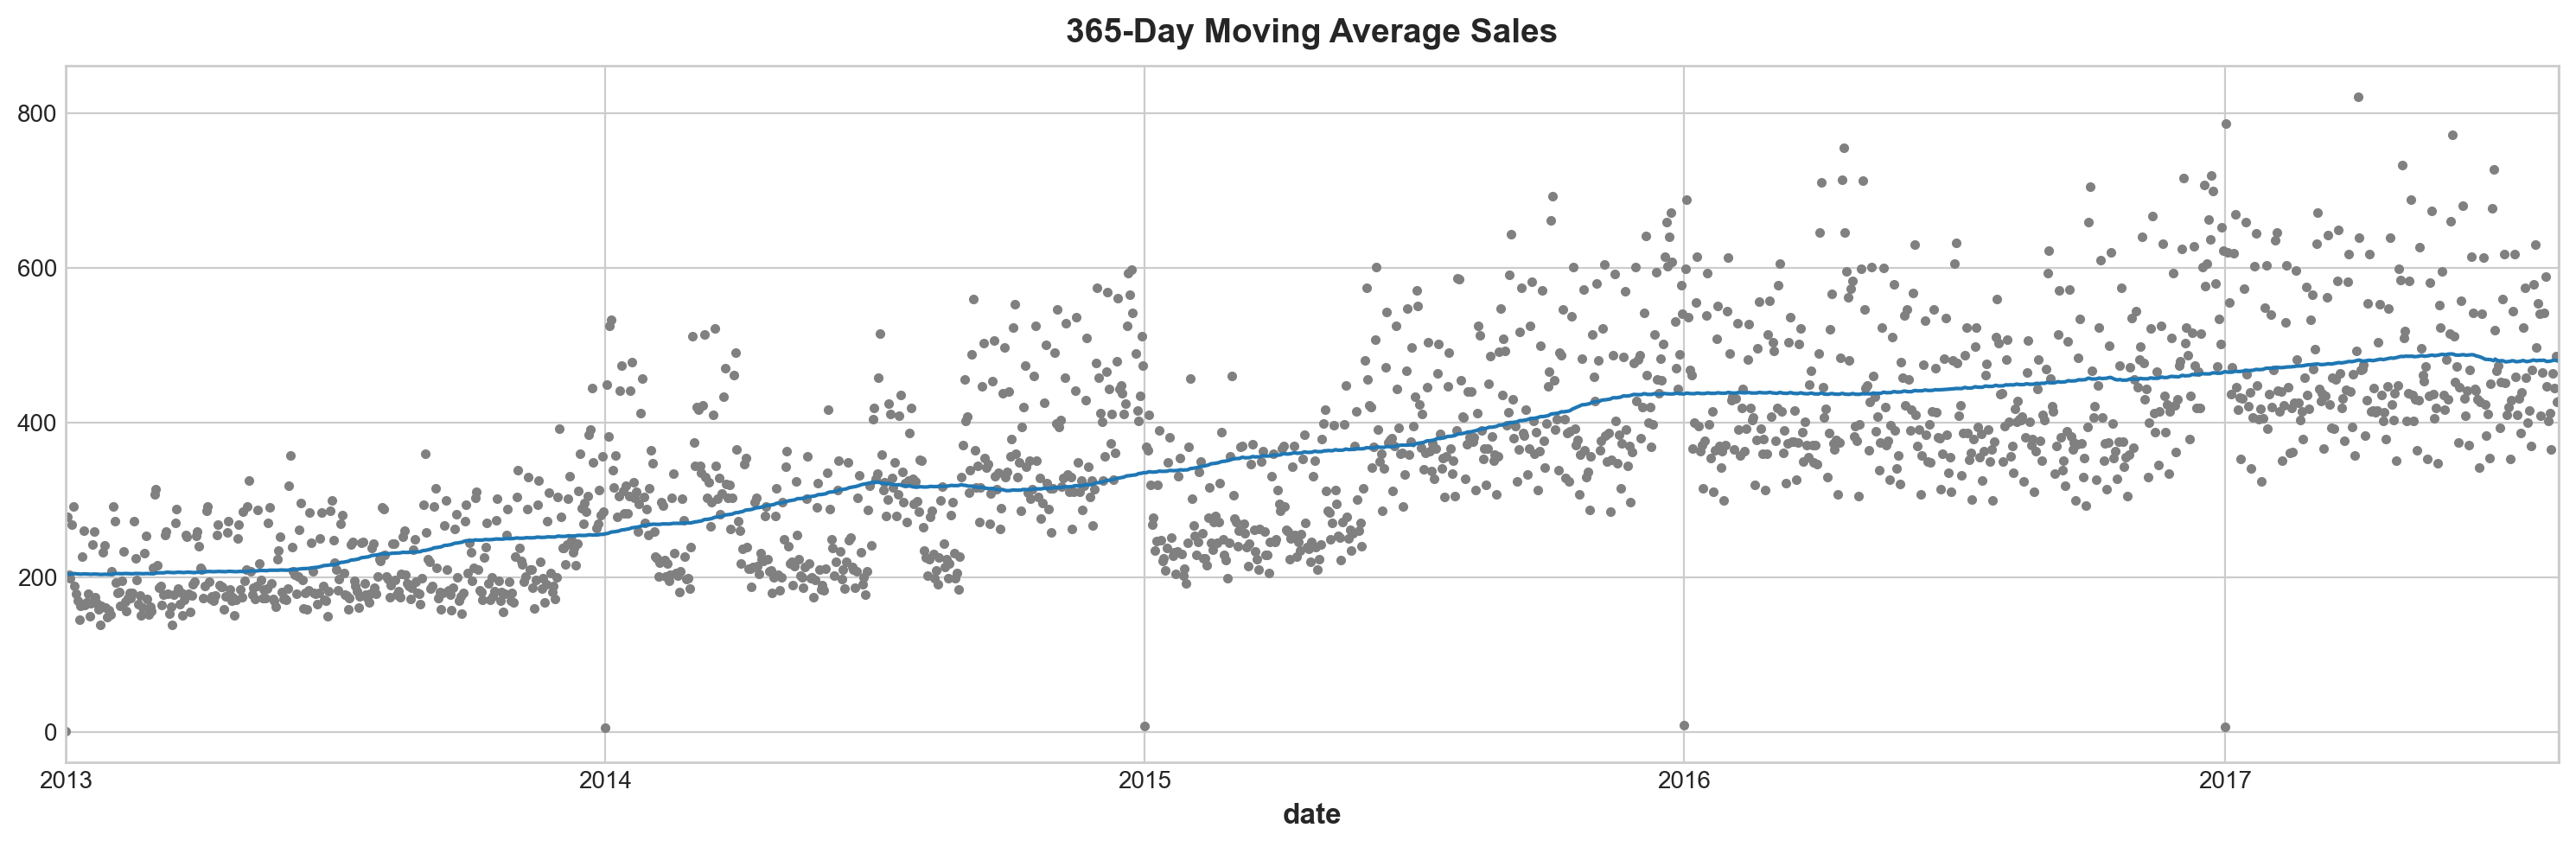

In [70]:
plt.subplots(figsize=(15,5))
ax = avg_sales.plot(style='.', color='0.5')
moving_avg.plot(ax=ax)
ax.set_title('365-Day Moving Average Sales')

In [14]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=avg_sales.index,
    order=3,
    drop=True
)

X = dp.in_sample()
X.head()

trend  trend_squared  trend_cubed
date                                         
2013-01-01    1.0            1.0          1.0
2013-01-02    2.0            4.0          8.0
2013-01-03    3.0            9.0         27.0
2013-01-04    4.0           16.0         64.0
2013-01-05    5.0           25.0        125.0

In [125]:
y = df.sales

lr = LinearRegression()
lr.fit(X, y)
y_pred = pd.Series(lr.predict(X), index=X.index)

In [126]:
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(lr.predict(X), index=X.index)

<Axes: xlabel='date'>

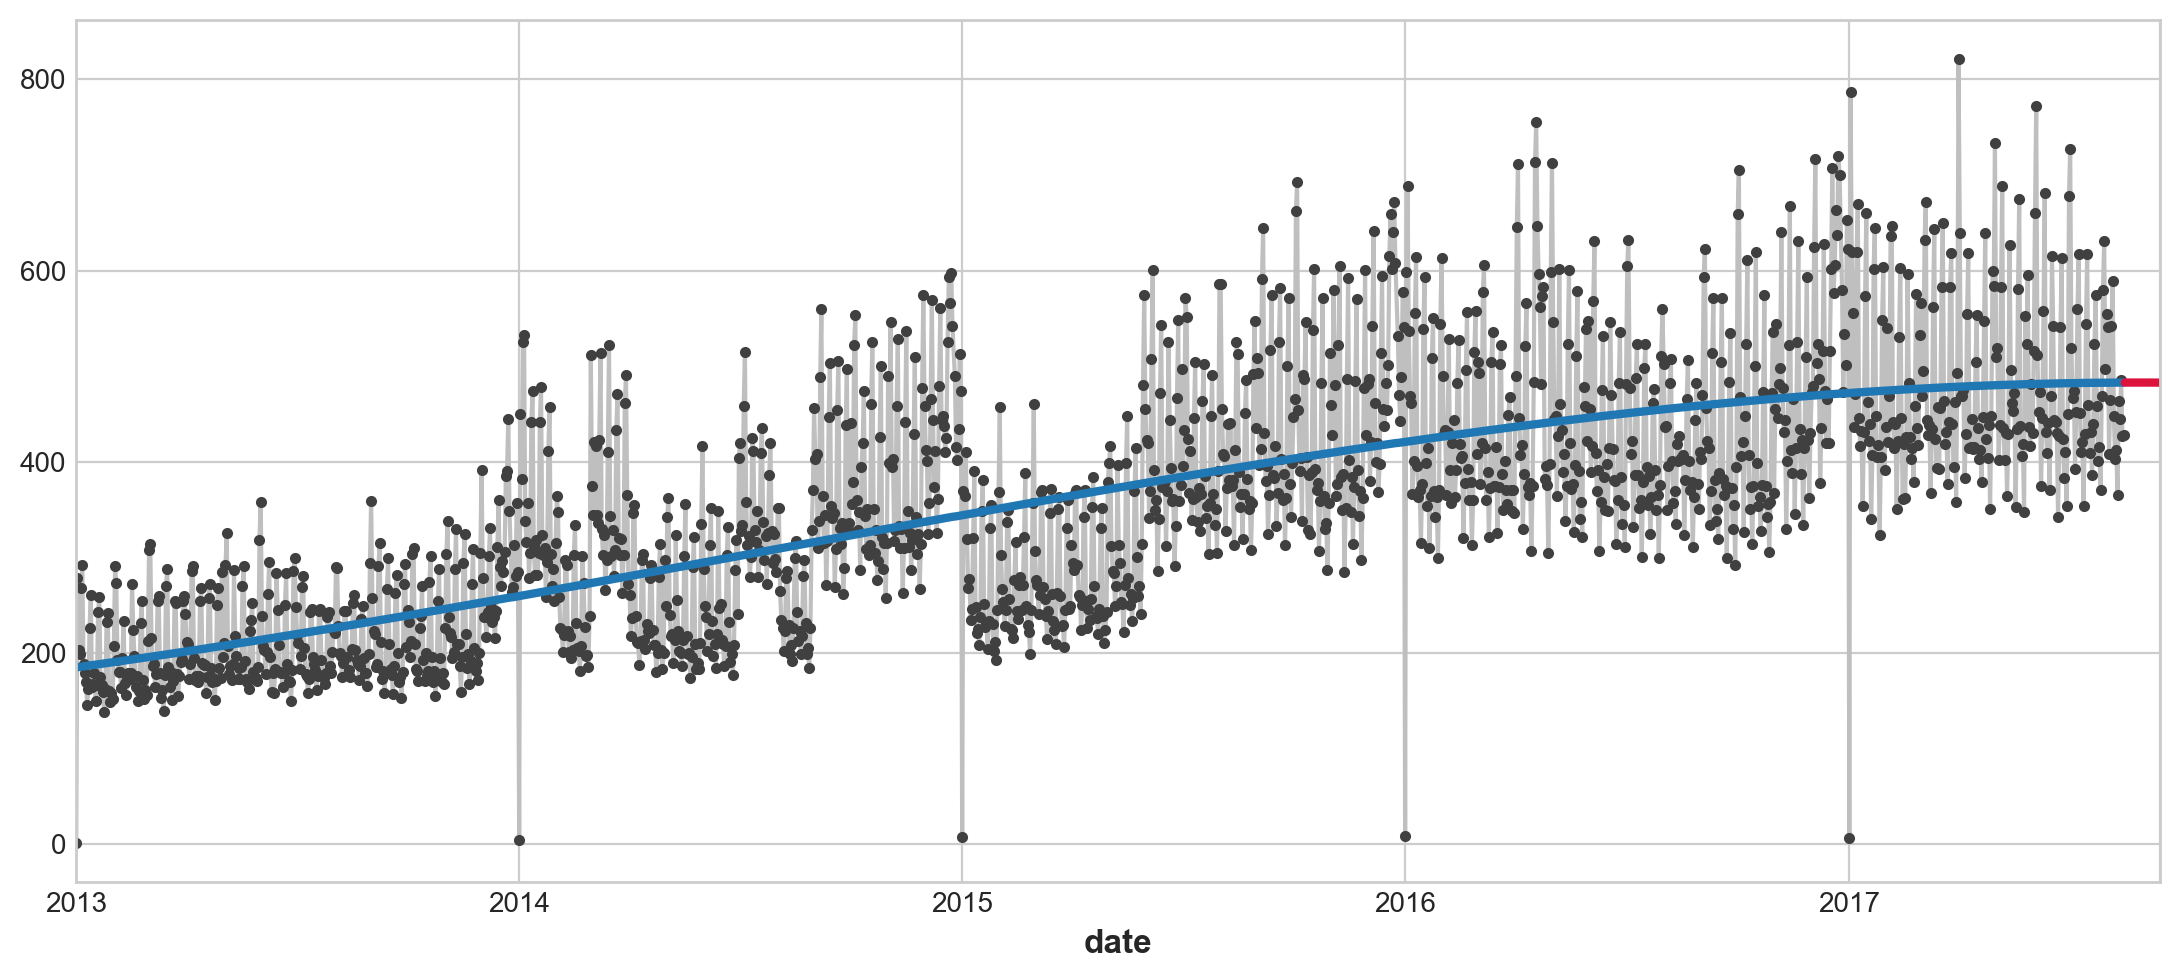

In [127]:
avg_sales.plot(**plot_params)
y_pred.plot(style='-', linewidth=3)
y_fore.plot(style='-', color='crimson', linewidth=3)

In [116]:
from sklearn.metrics import mean_squared_error

# order = 1
mean_squared_error(y, y_pred, squared=False)

91.47321426070182

In [122]:
# order = 3
mean_squared_error(y, y_pred, squared=False)

90.6782656407637

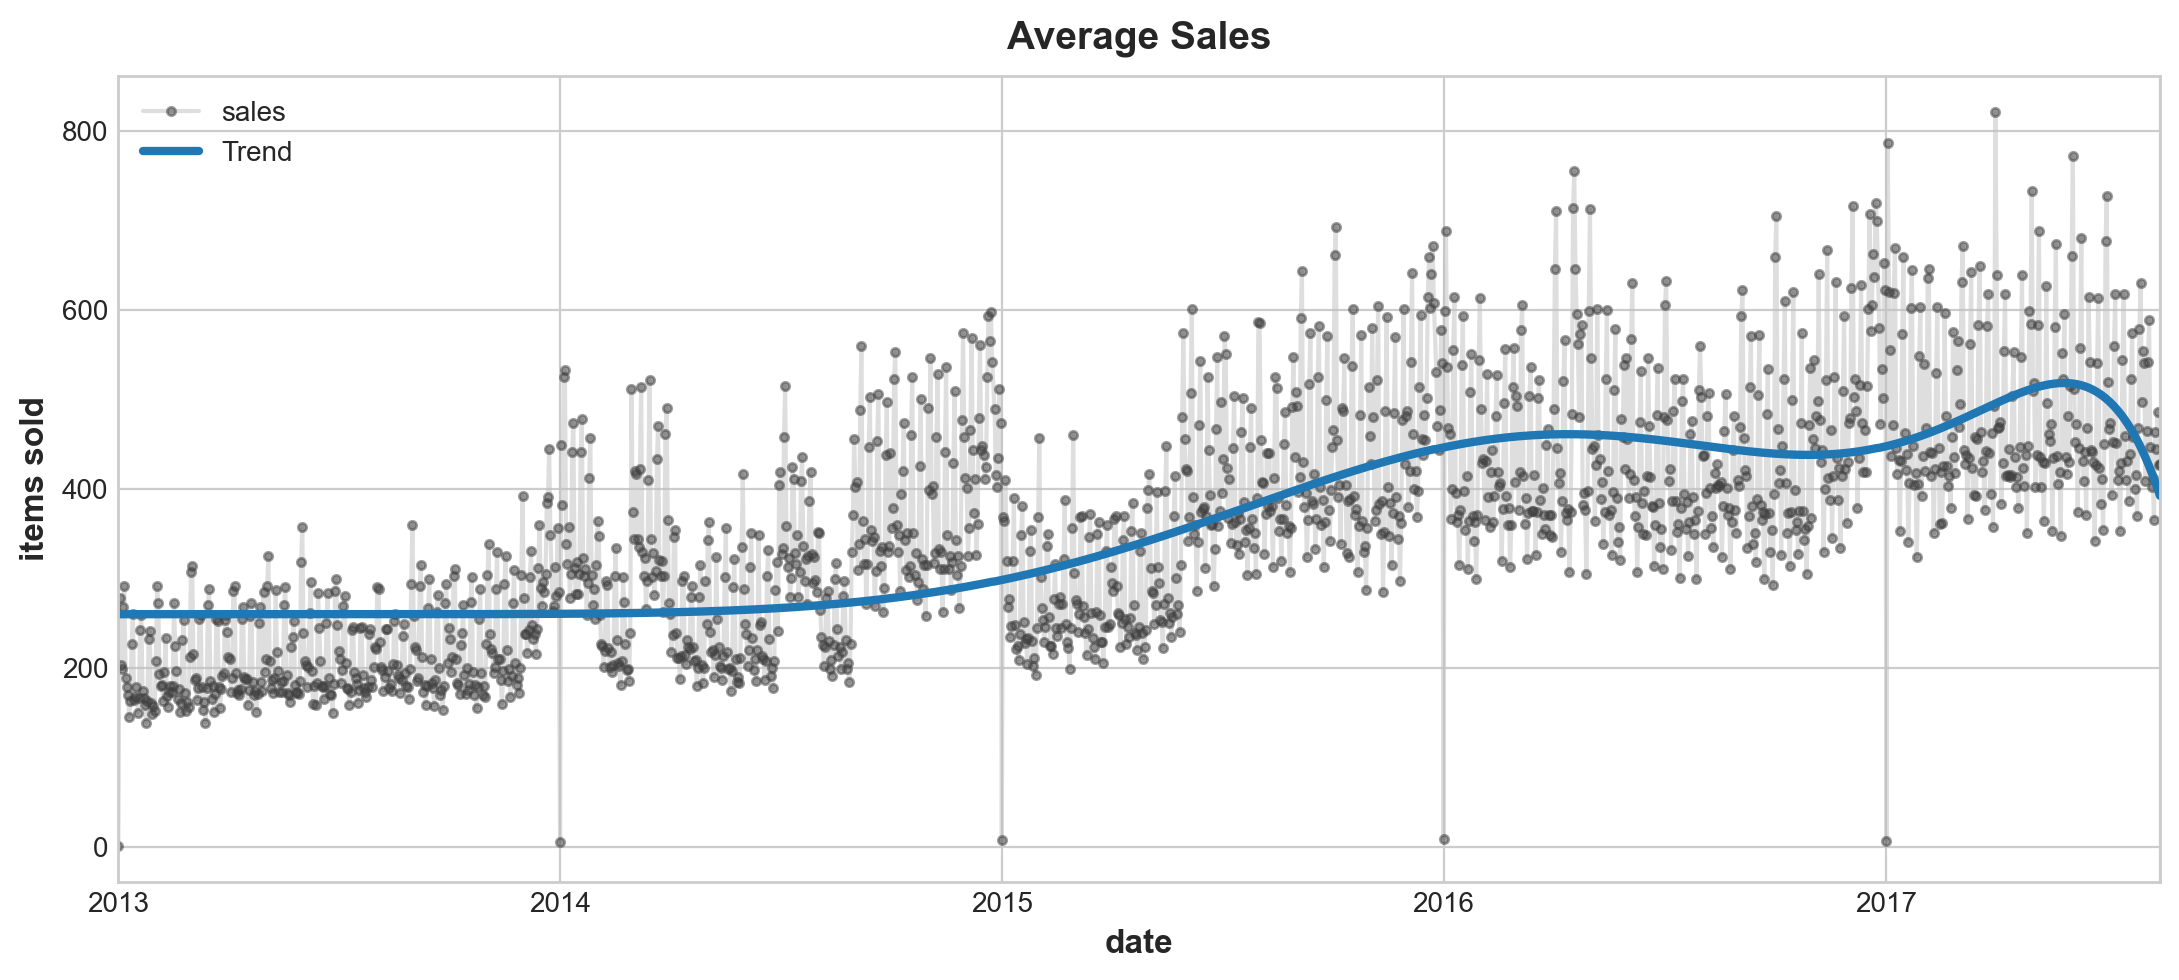

In [135]:
dp = DeterministicProcess(
    index=df.index,
    order=11
)
X = dp.in_sample()
lr.fit(X,y)
y_pred = pd.Series(lr.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend()

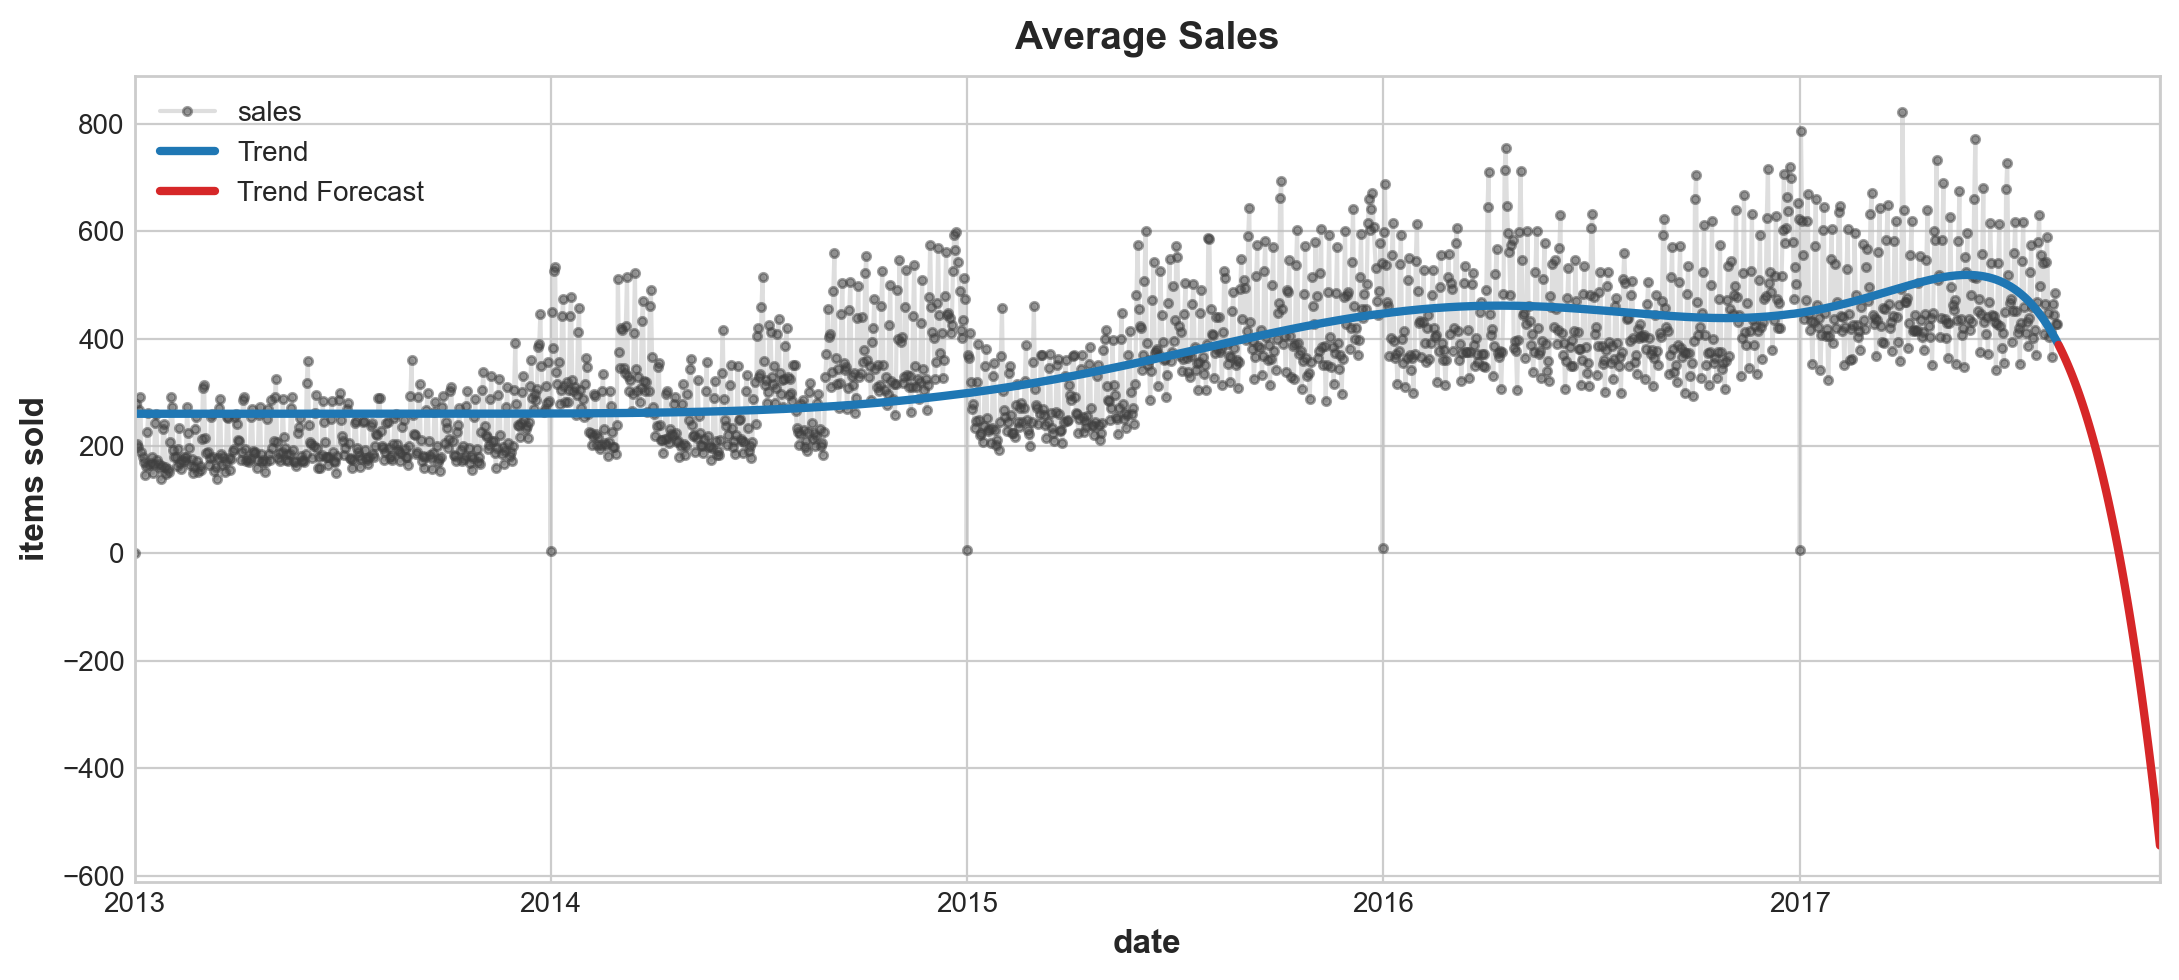

In [136]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(lr.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

In [137]:
# order = 11
mean_squared_error(y, y_pred, squared=False)

94.727558271353

In [17]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [139]:
df.index.day_of_week

Index([1, 2, 3, 4, 5, 6, 0, 1, 2, 3,
       ...
       6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
      dtype='int64', name='date', length=1684)

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

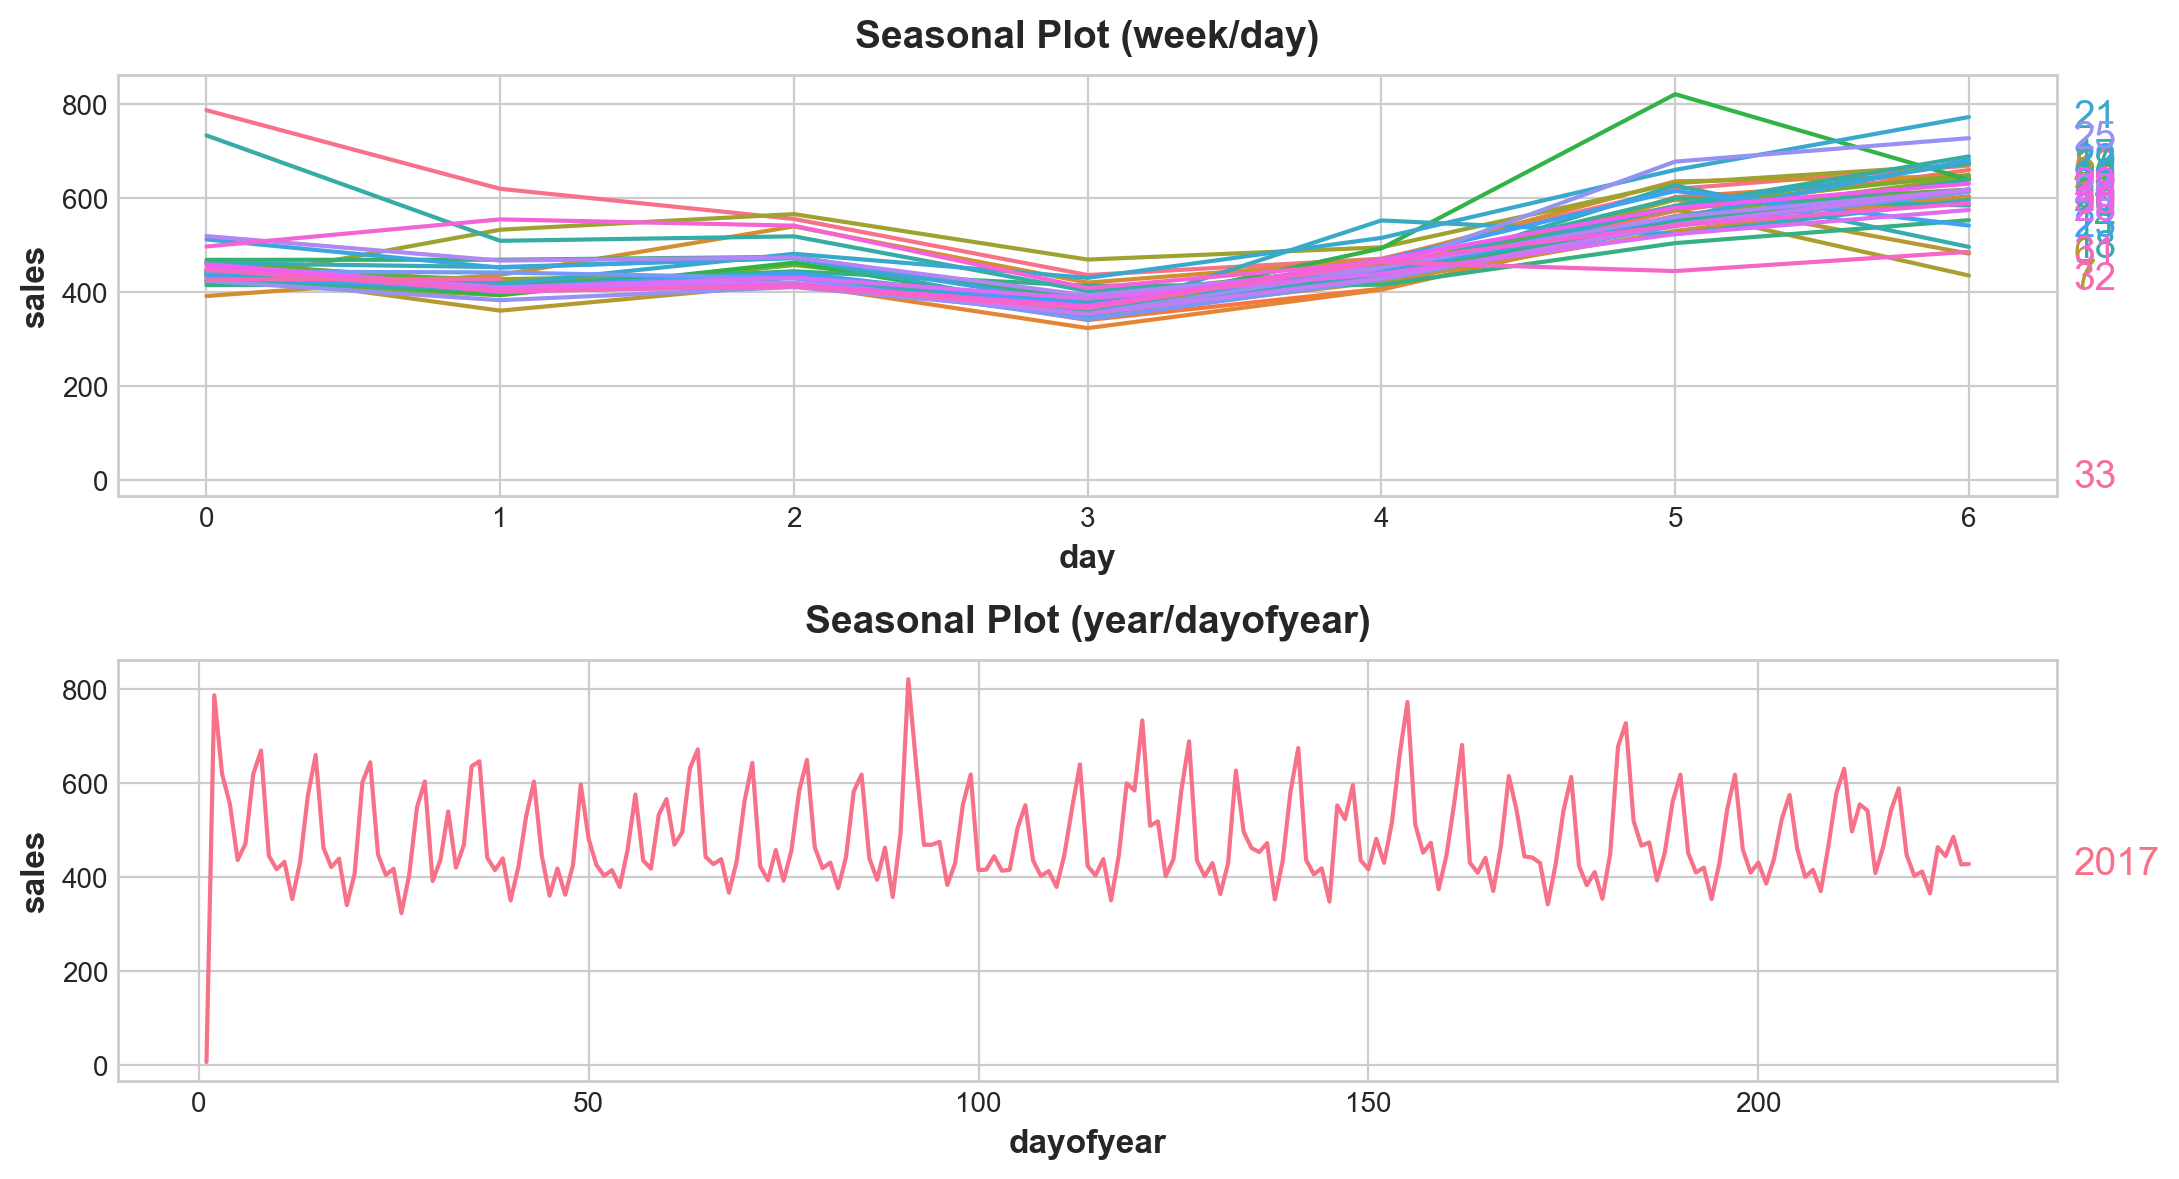

In [159]:
df['day'] = df.index.day_of_week
df['week'] = df.index.week
df['dayofyear'] = df.index.day_of_year
df['year'] = df.index.year

df = df.loc['2017']
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(df, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(df, y="sales", period="year", freq="dayofyear", ax=ax1)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

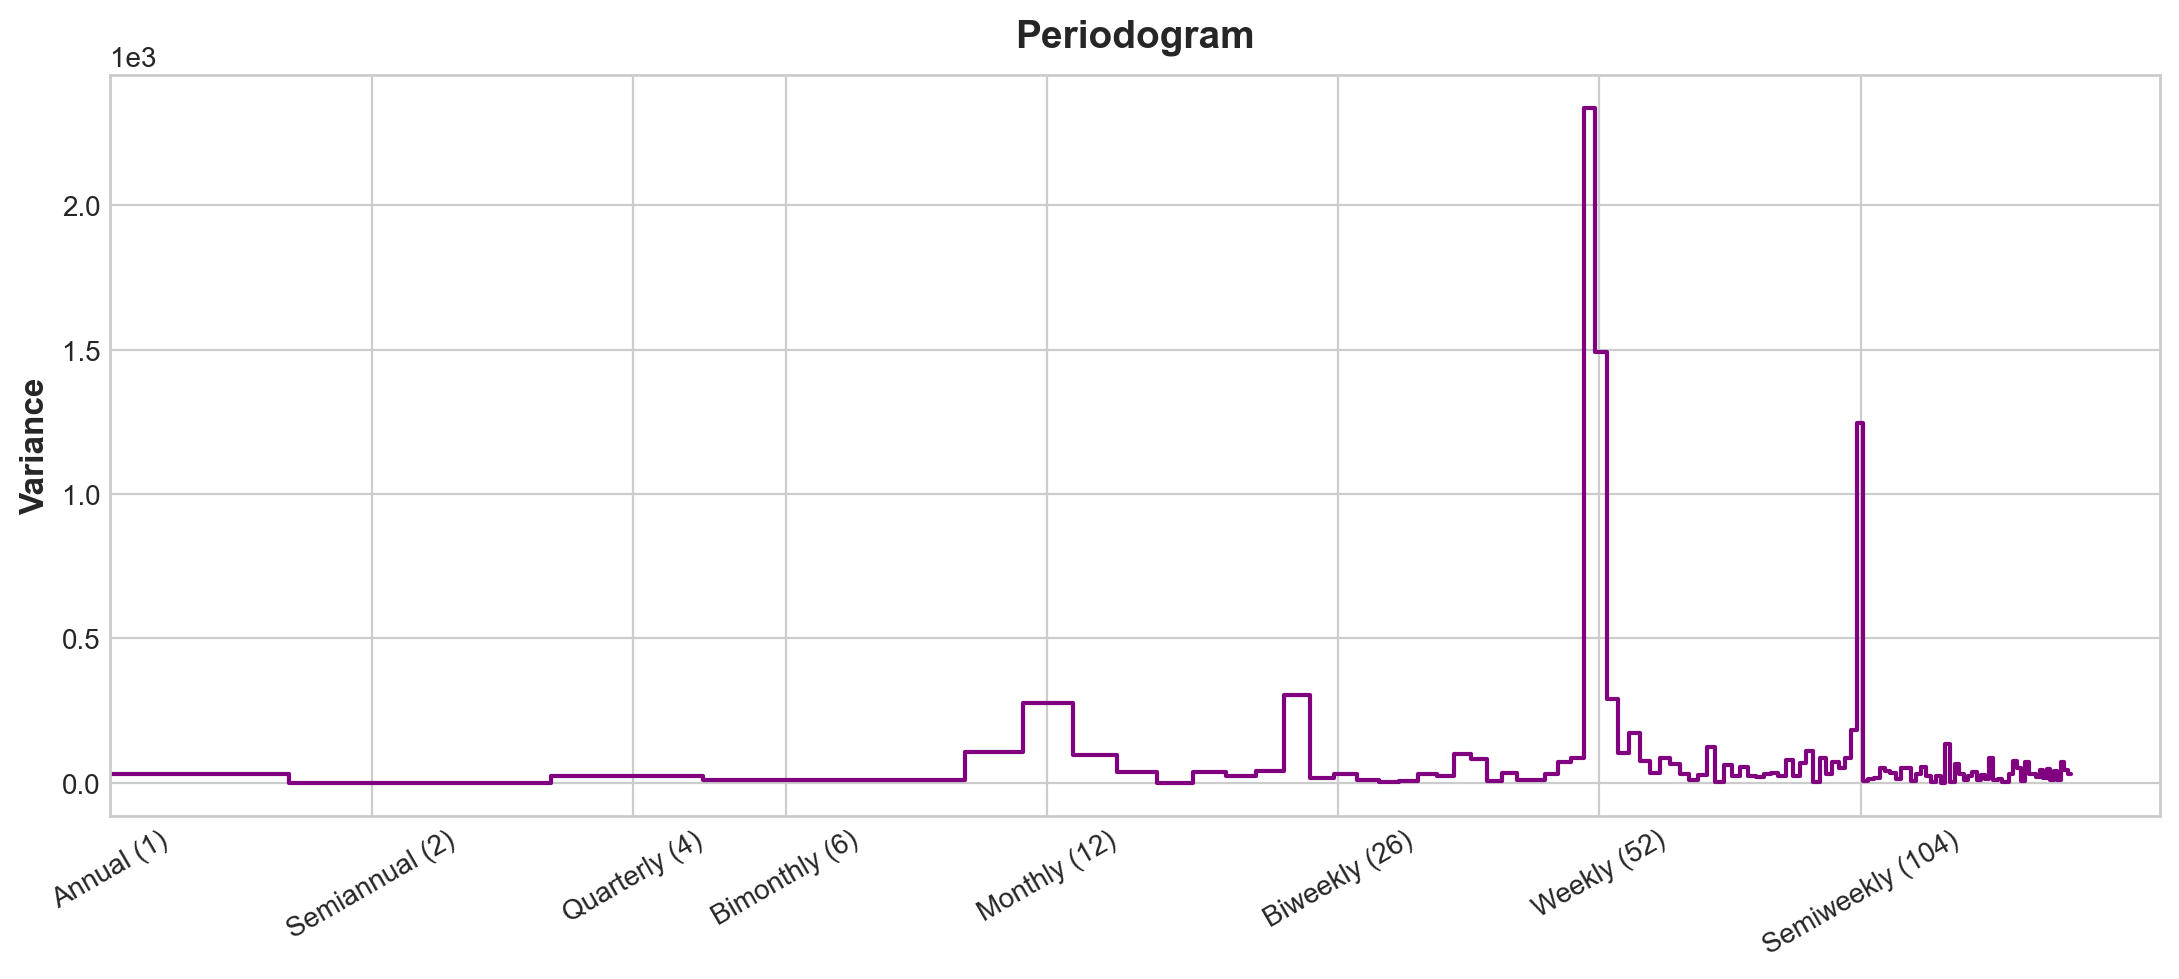

In [160]:
plot_periodogram(df.sales)

<Axes: xlabel='date'>

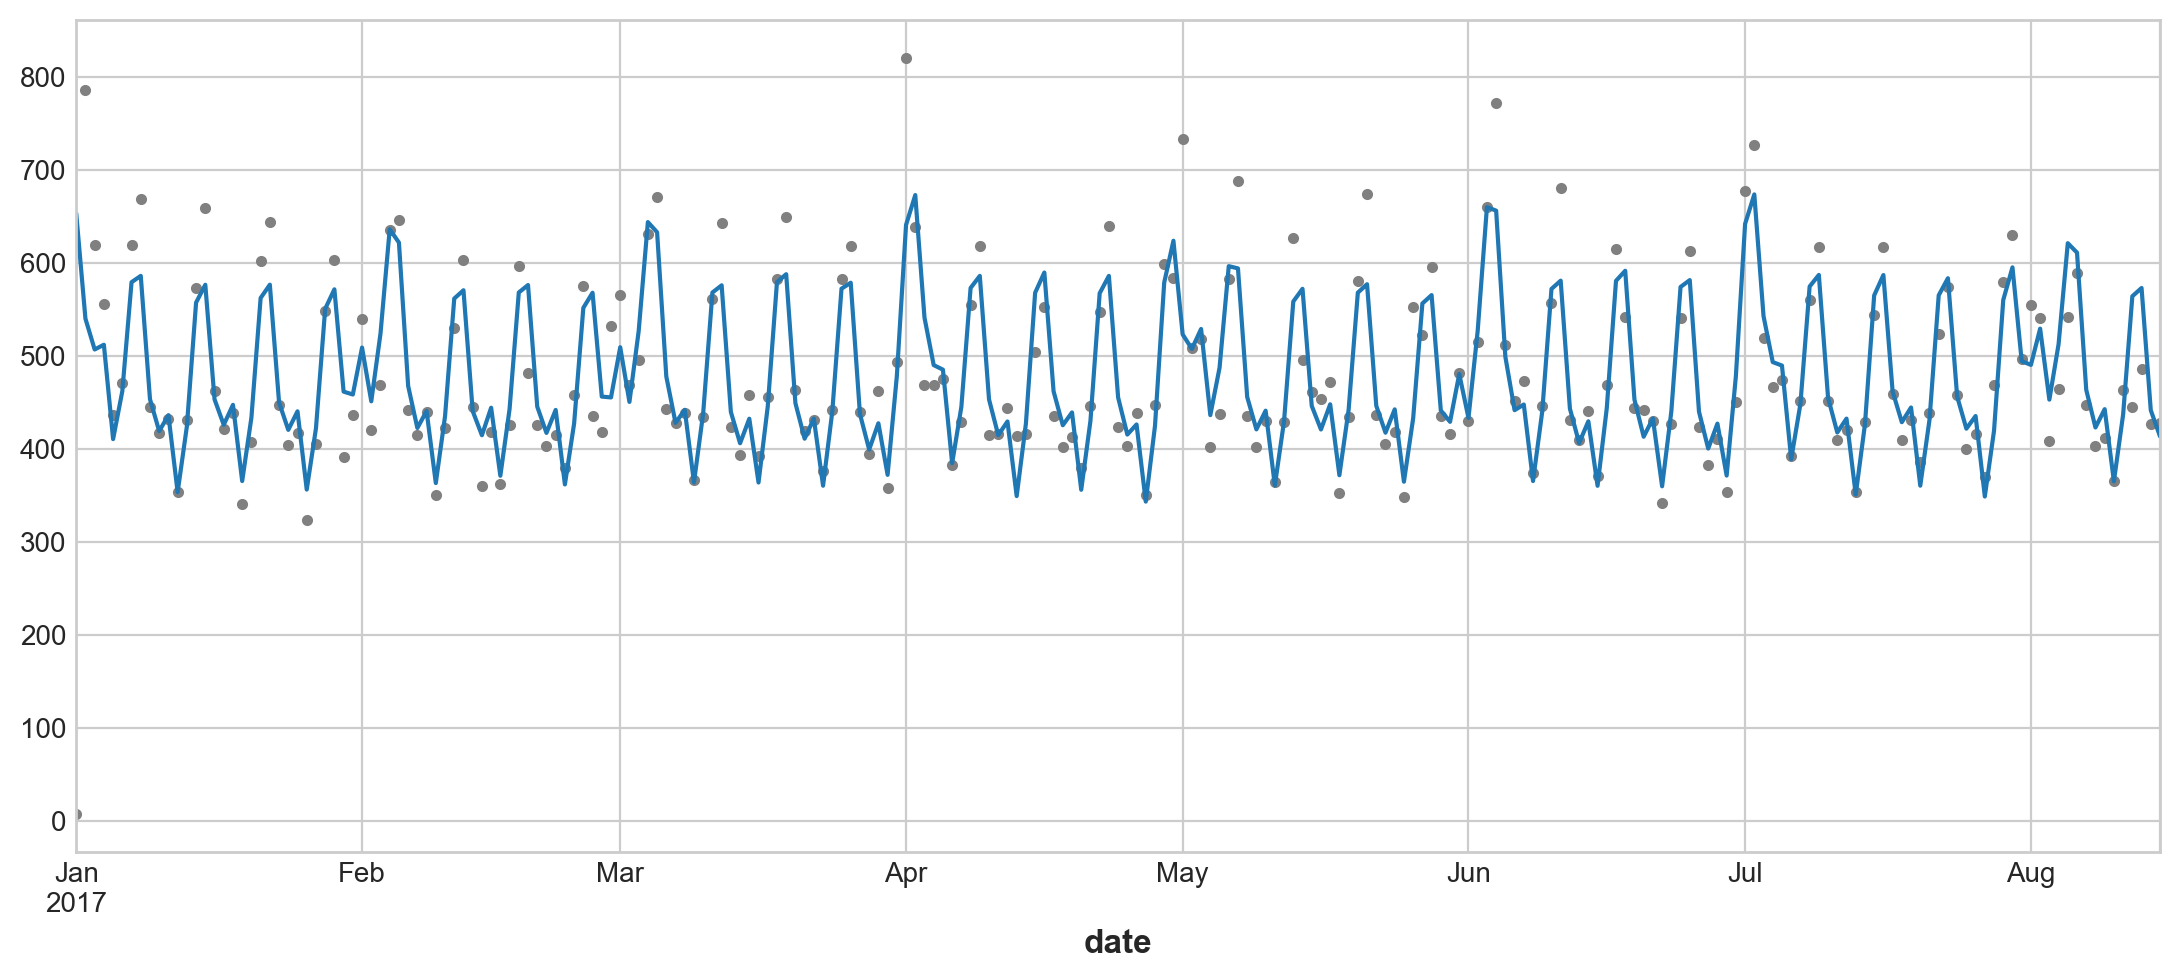

In [184]:
fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=df.index,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()
lr.fit(X, y.loc['2017'])
y_pred = pd.Series(lr.predict(X), index=X.index)

df.sales.plot(style='.', color='0.5')
y_pred.plot(style='-')



In [185]:
mean_squared_error(y.loc['2017'], y_pred, squared=False)

61.21527415255703

**Deseasionalized**

Text(0.5, 1.0, 'Deseasonalized')

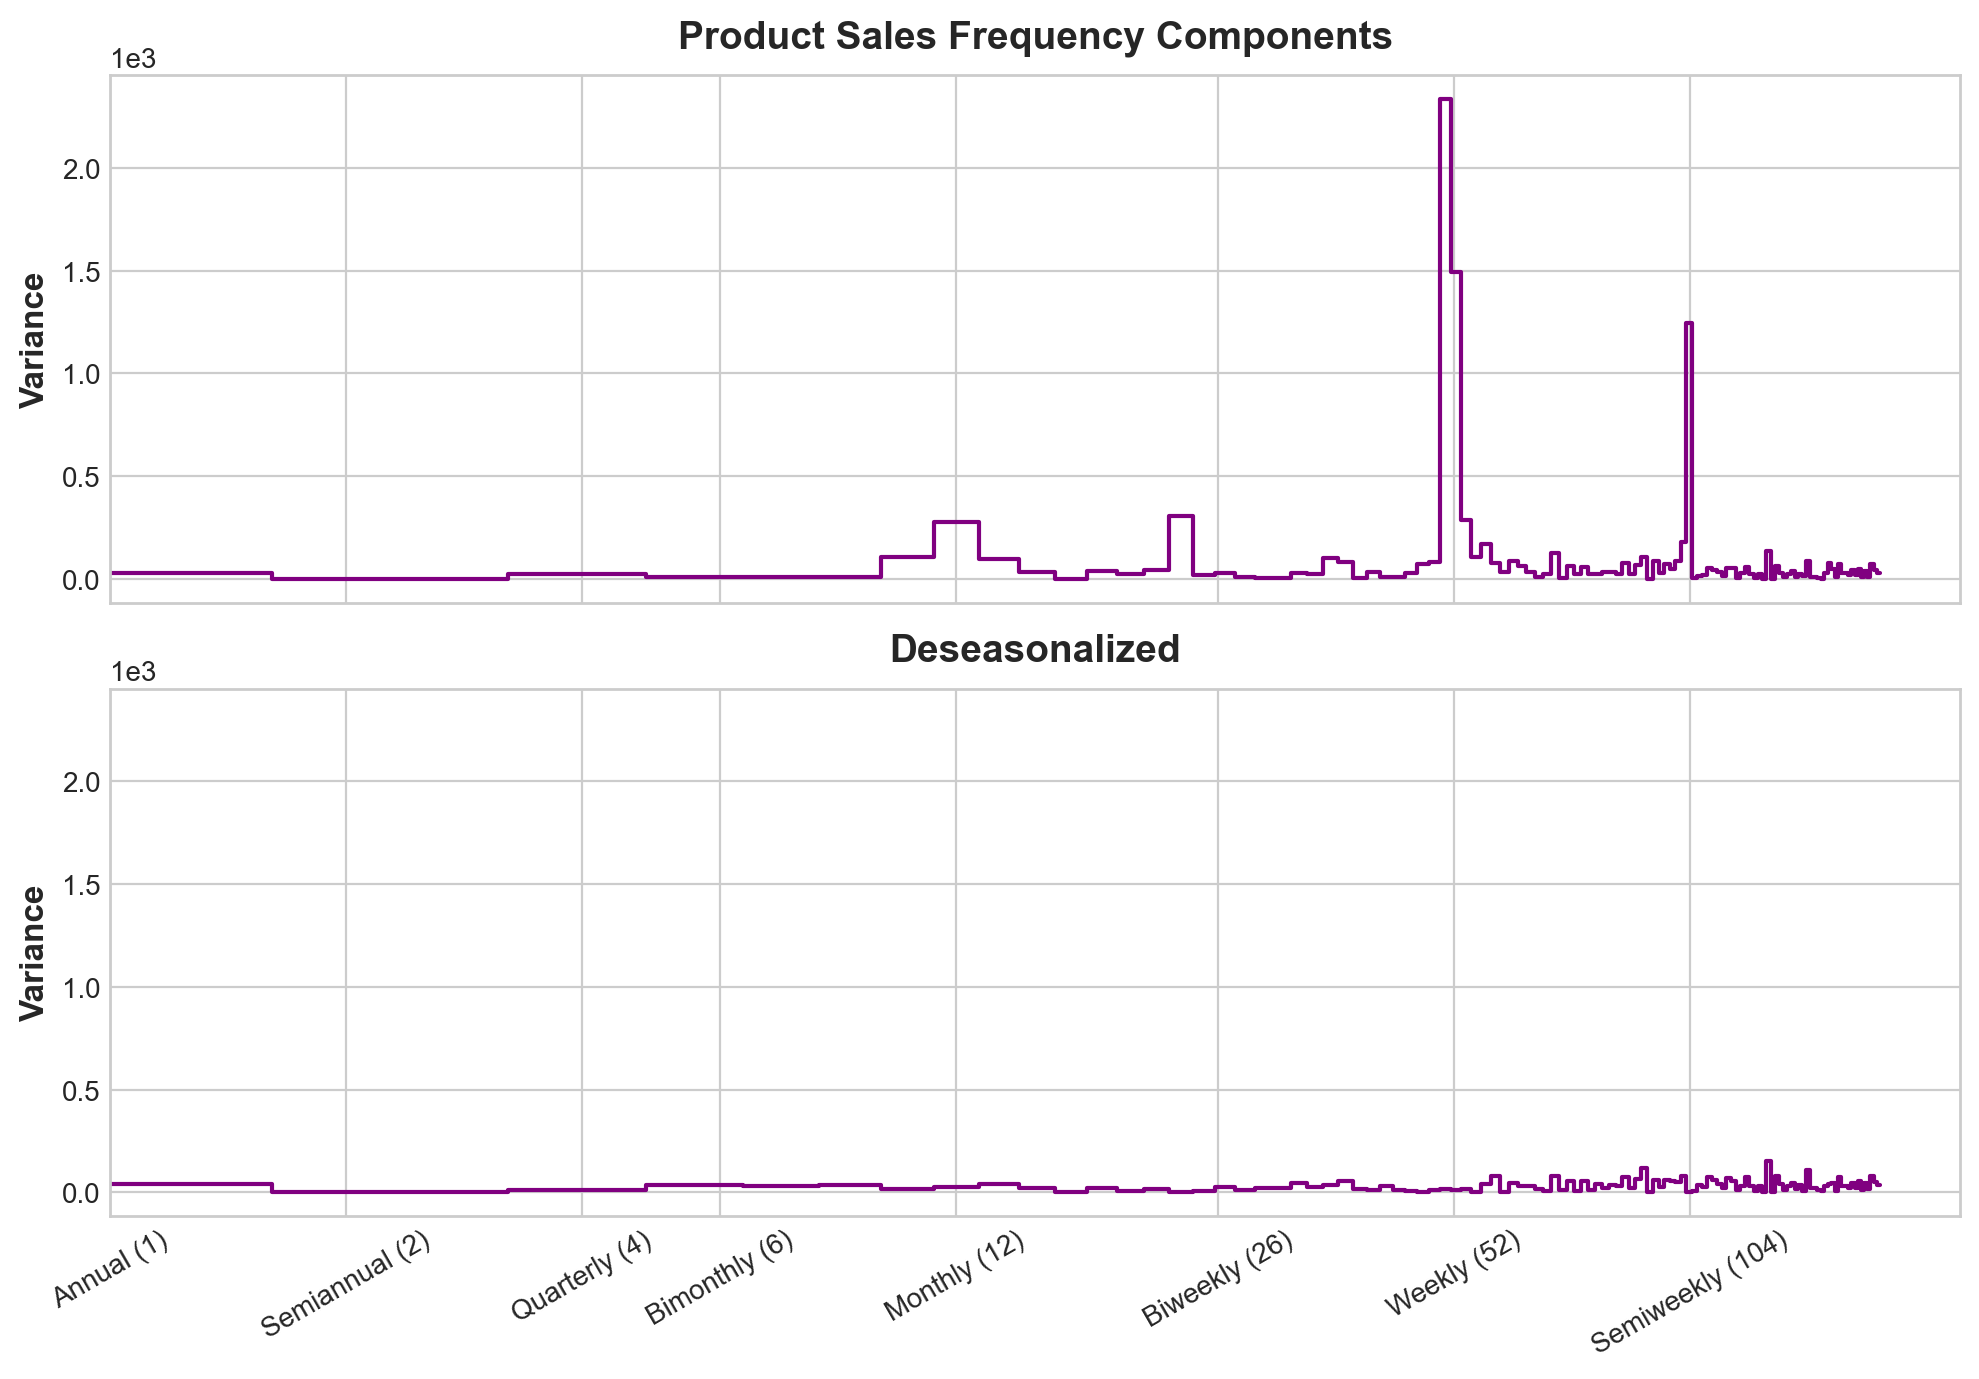

In [188]:
y_deseason = y.loc['2017'] - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y.loc['2017'], ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized")

<Axes: xlabel='date'>

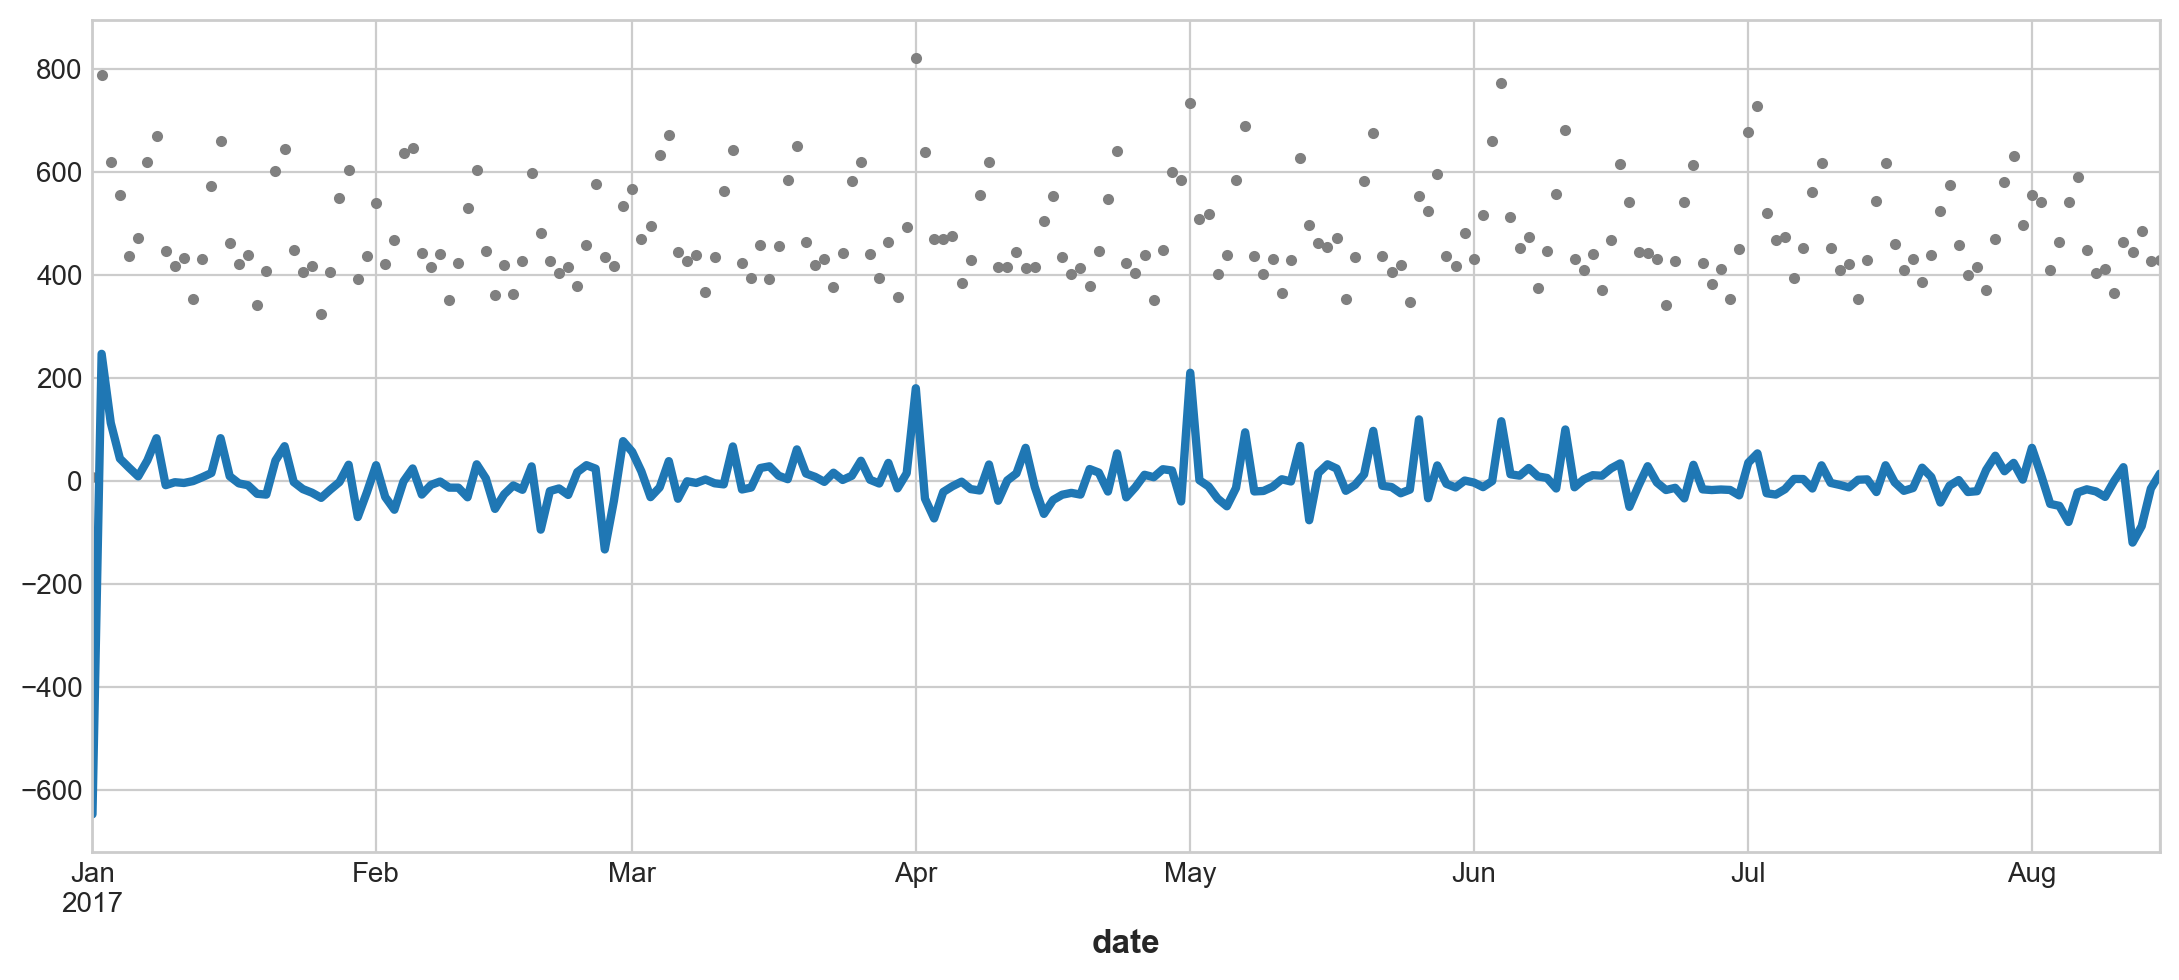

In [189]:
y.loc['2017'].plot(style='.', color='0.5')
y_deseason.plot(style='', linewidth=3)

In [175]:
# National and regional holidays in the training set
holidays_events = pd.read_csv(
    path/"holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

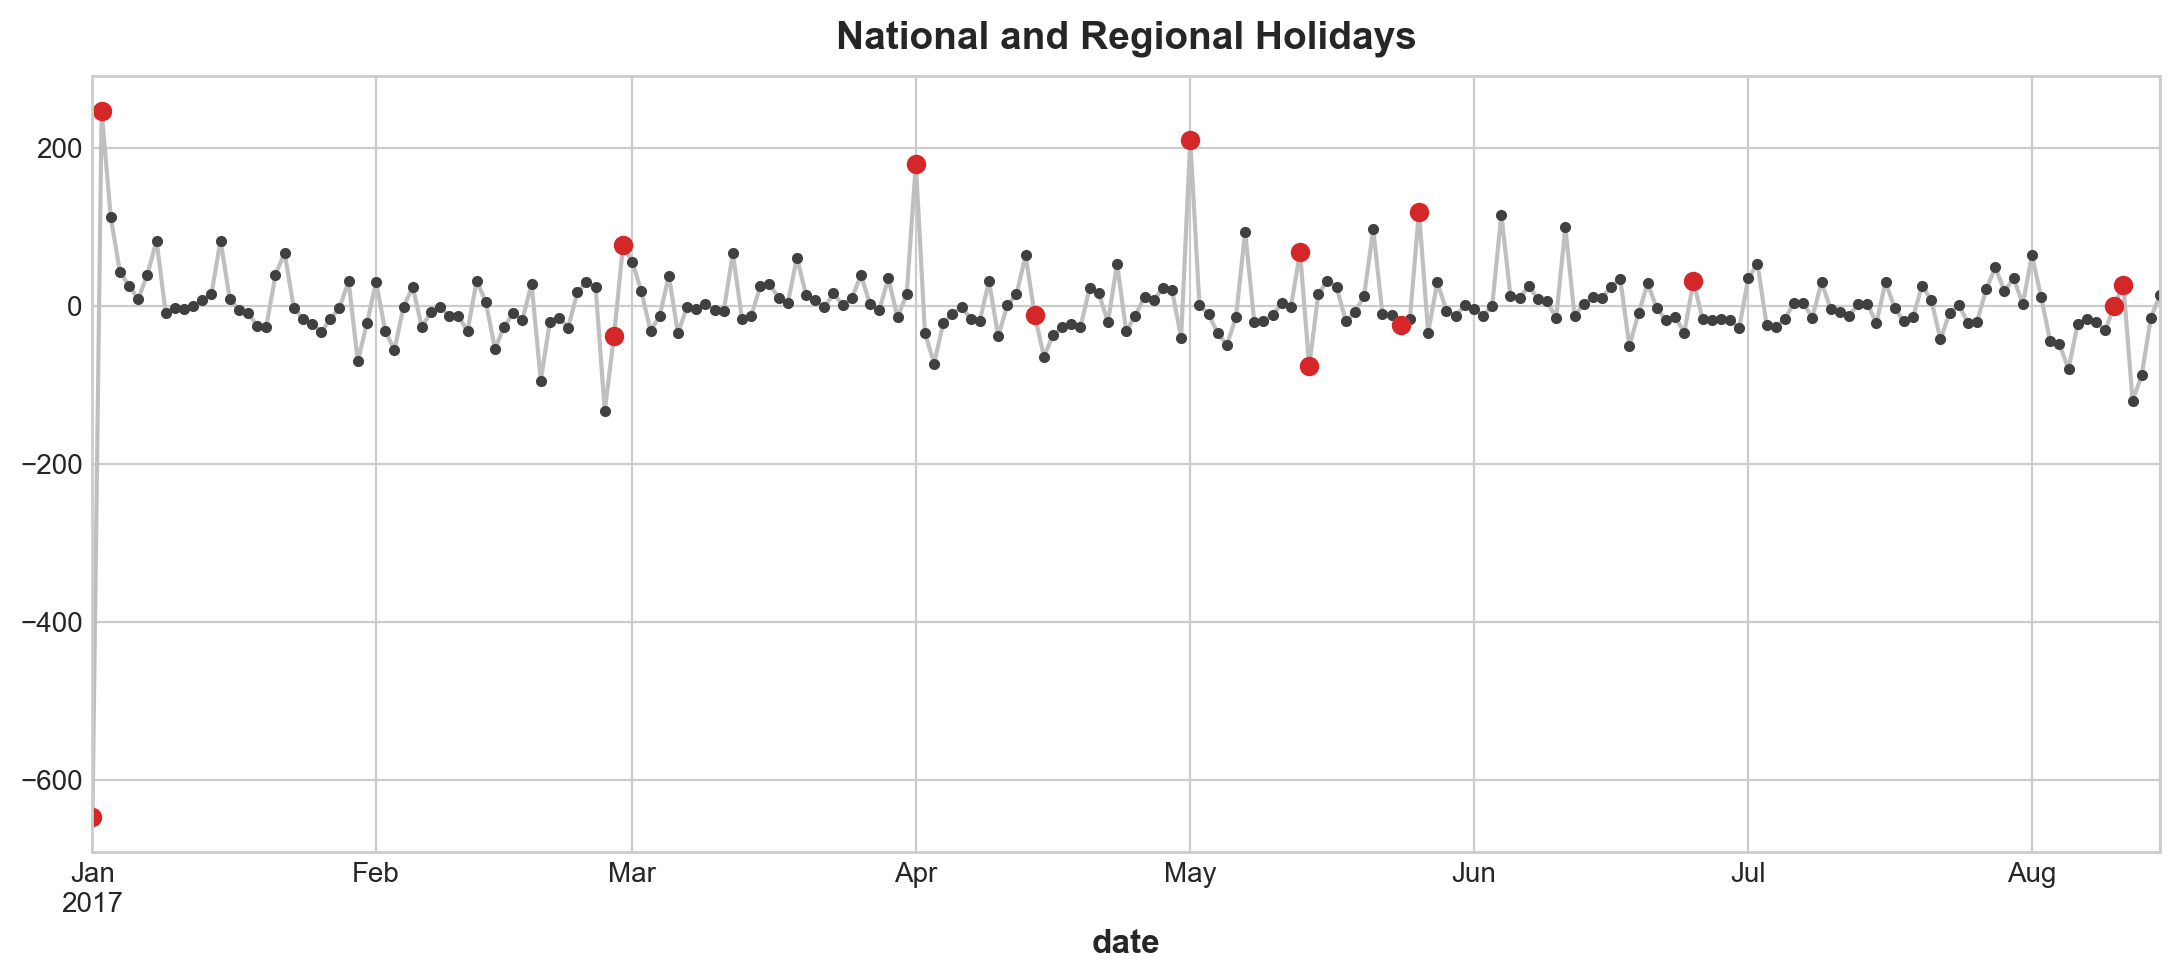

In [190]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [194]:
X_holidays = pd.get_dummies(holidays)
X2 = X.join(X_holidays, on='date').fillna(0)

In [195]:
X2.columns

Index(['trend', 's(1,7)', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=ME)', 'cos(1,freq=ME)', 'sin(2,freq=ME)',
       'cos(2,freq=ME)', 'sin(3,freq=ME)', 'cos(3,freq=ME)', 'sin(4,freq=ME)',
       'cos(4,freq=ME)', 'description_Batalla de Pichincha',
       'description_Carnaval', 'description_Dia de la Madre',
       'description_Dia de la Madre-1', 'description_Dia del Trabajo',
       'description_Primer Grito de Independencia',
       'description_Primer dia del ano',
       'description_Provincializacion de Cotopaxi',
       'description_Provincializacion de Imbabura',
       'description_Traslado Batalla de Pichincha',
       'description_Traslado Primer Grito de Independencia',
       'description_Traslado Primer dia del ano', 'description_Viernes Santo'],
      dtype='object')

We should put some examples of this in the documentation.

In short, a higher order means we have higher frequency terms and so will be able to fit more quickly-changing and complex seasonality patterns.

This figure from Wikipedia shows a Fourier series approximation to a square wave, with 1, 2, 3, and 4 components: https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg . You can see that as the order is increased, the Fourier series is able to better represent the quick change of the square wave. The downside of using a very high order is just that it is more terms in the model and so overfitting becomes a risk.

The default of 10 typically is appropriate for seasonality on the scale of a year. If it looks like your seasonality effect changes very quickly and the Prophet seaosnality estimate is lagging and not able to capture it all, then try increasing the order.

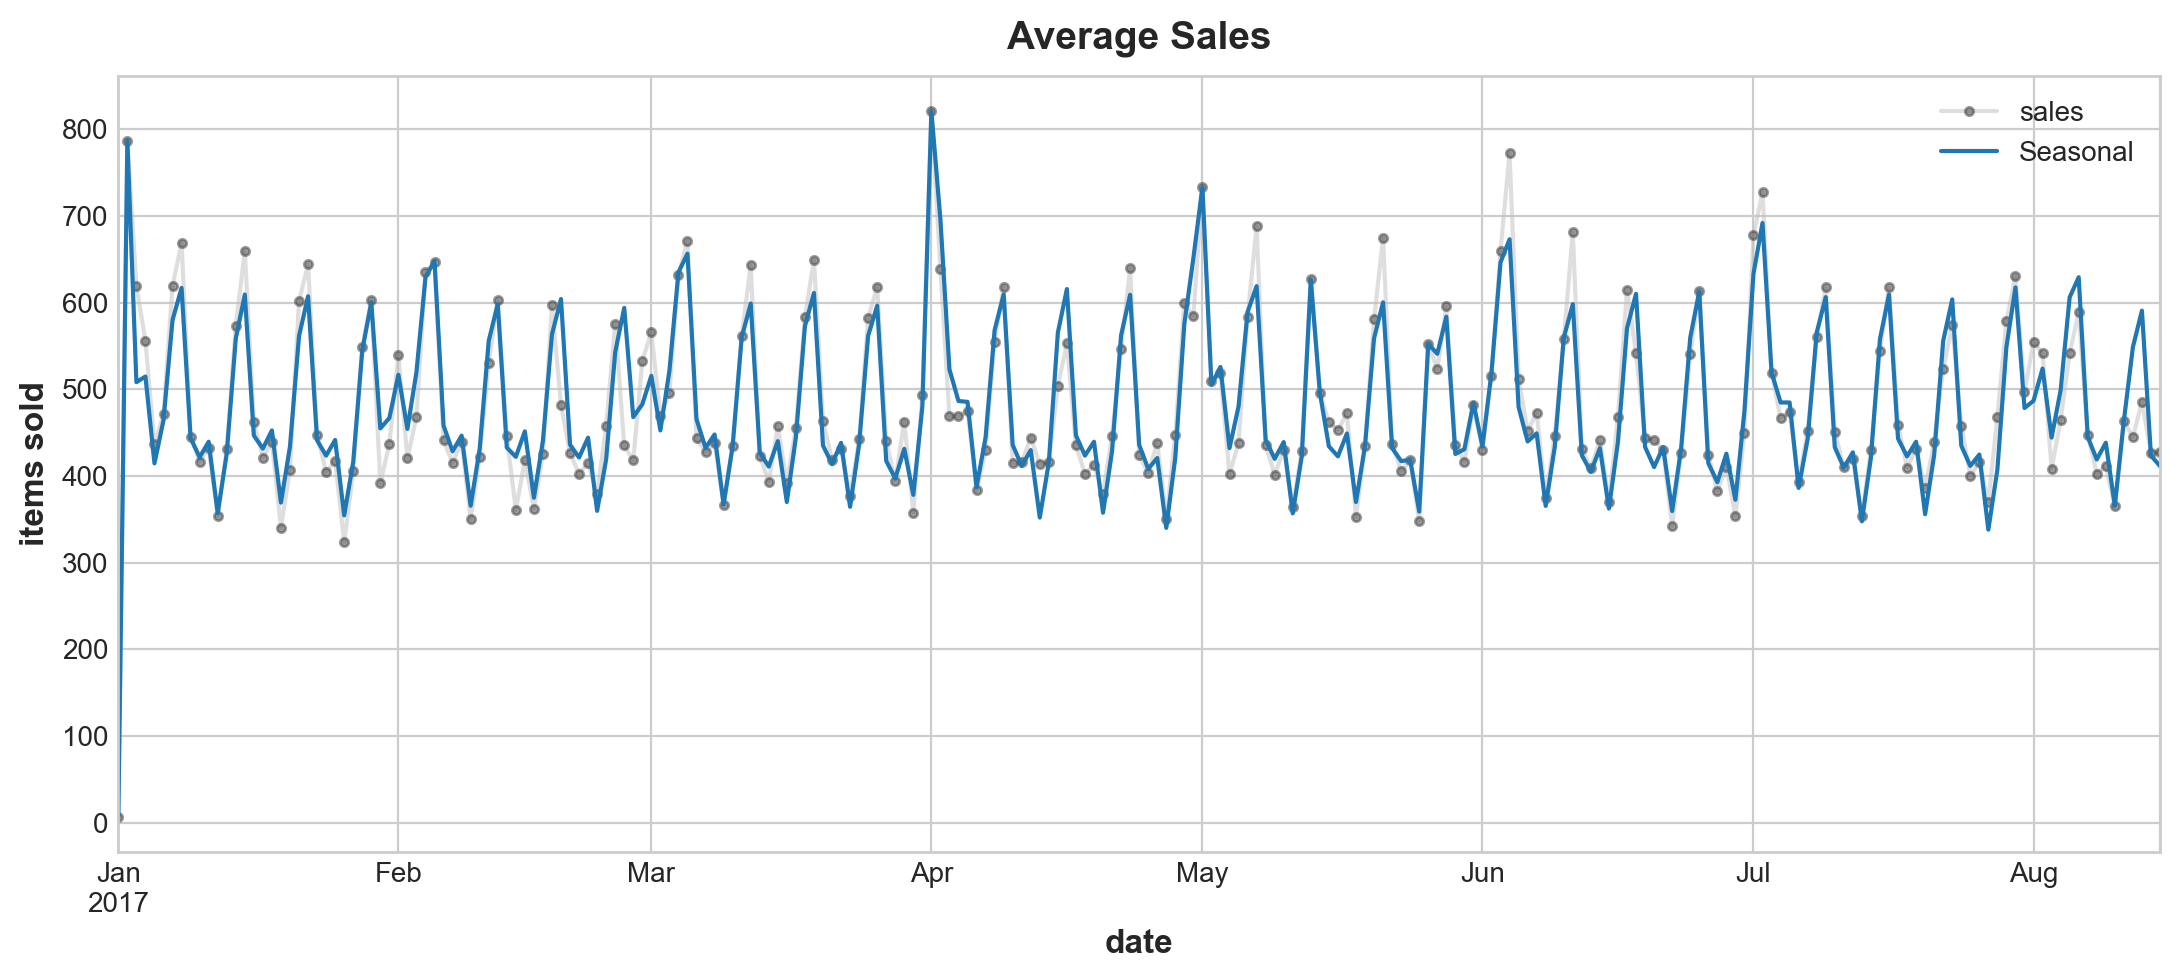

In [196]:
model = LinearRegression().fit(X2, y.loc['2017'])
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
)

ax = y.loc['2017'].plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [197]:
mean_squared_error(y.loc['2017'], y_pred, squared=False)

32.290522209785244

In [202]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

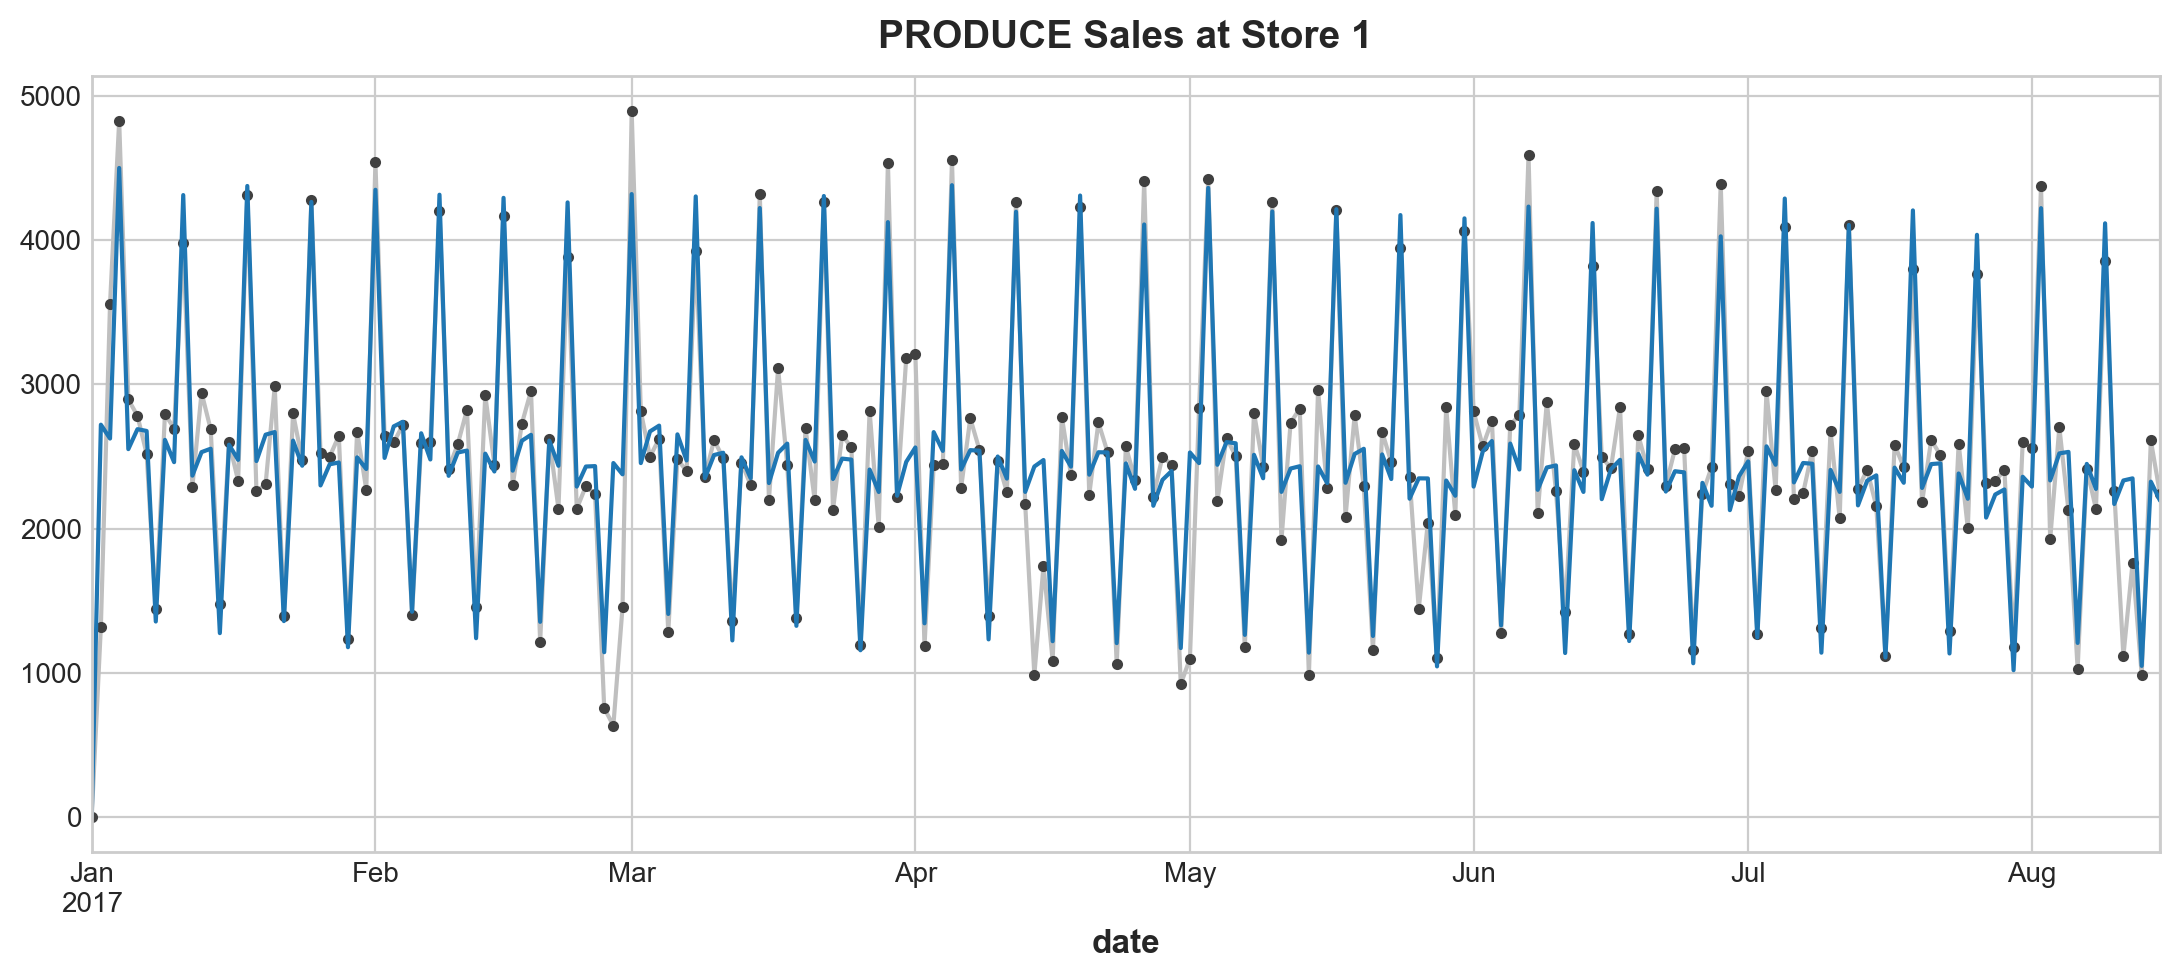

In [203]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [208]:
y.loc(axis=1)['sales']

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

store_nbr                                            ...         9  \
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

store_nbr                                                                  \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

store_nbr                                                                      \
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...                ...            ...          ...                        ...   
2017-08-11  525.223999     112.099998  1453.078003                      140.0   
2017-08-12  383.386993     129.903992  1419.264038                      138.0   
2017-08-13  412.458008     105.168999  1693.607056    

In [20]:
df_test = pd.read_csv(
    path / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(lr.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

# TIME SERIES AS FEATURES

In [49]:
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [11]:
supply_sales = family_sales.loc(axis=1)[:,'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:,'sales'].squeeze()

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely *cyclic* behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize *Supply Sales*. We'll store the result in a variable `y_deseason`.

Text(0.5, 1.0, 'Sales of School and Office Supplies (deseasonalized)')

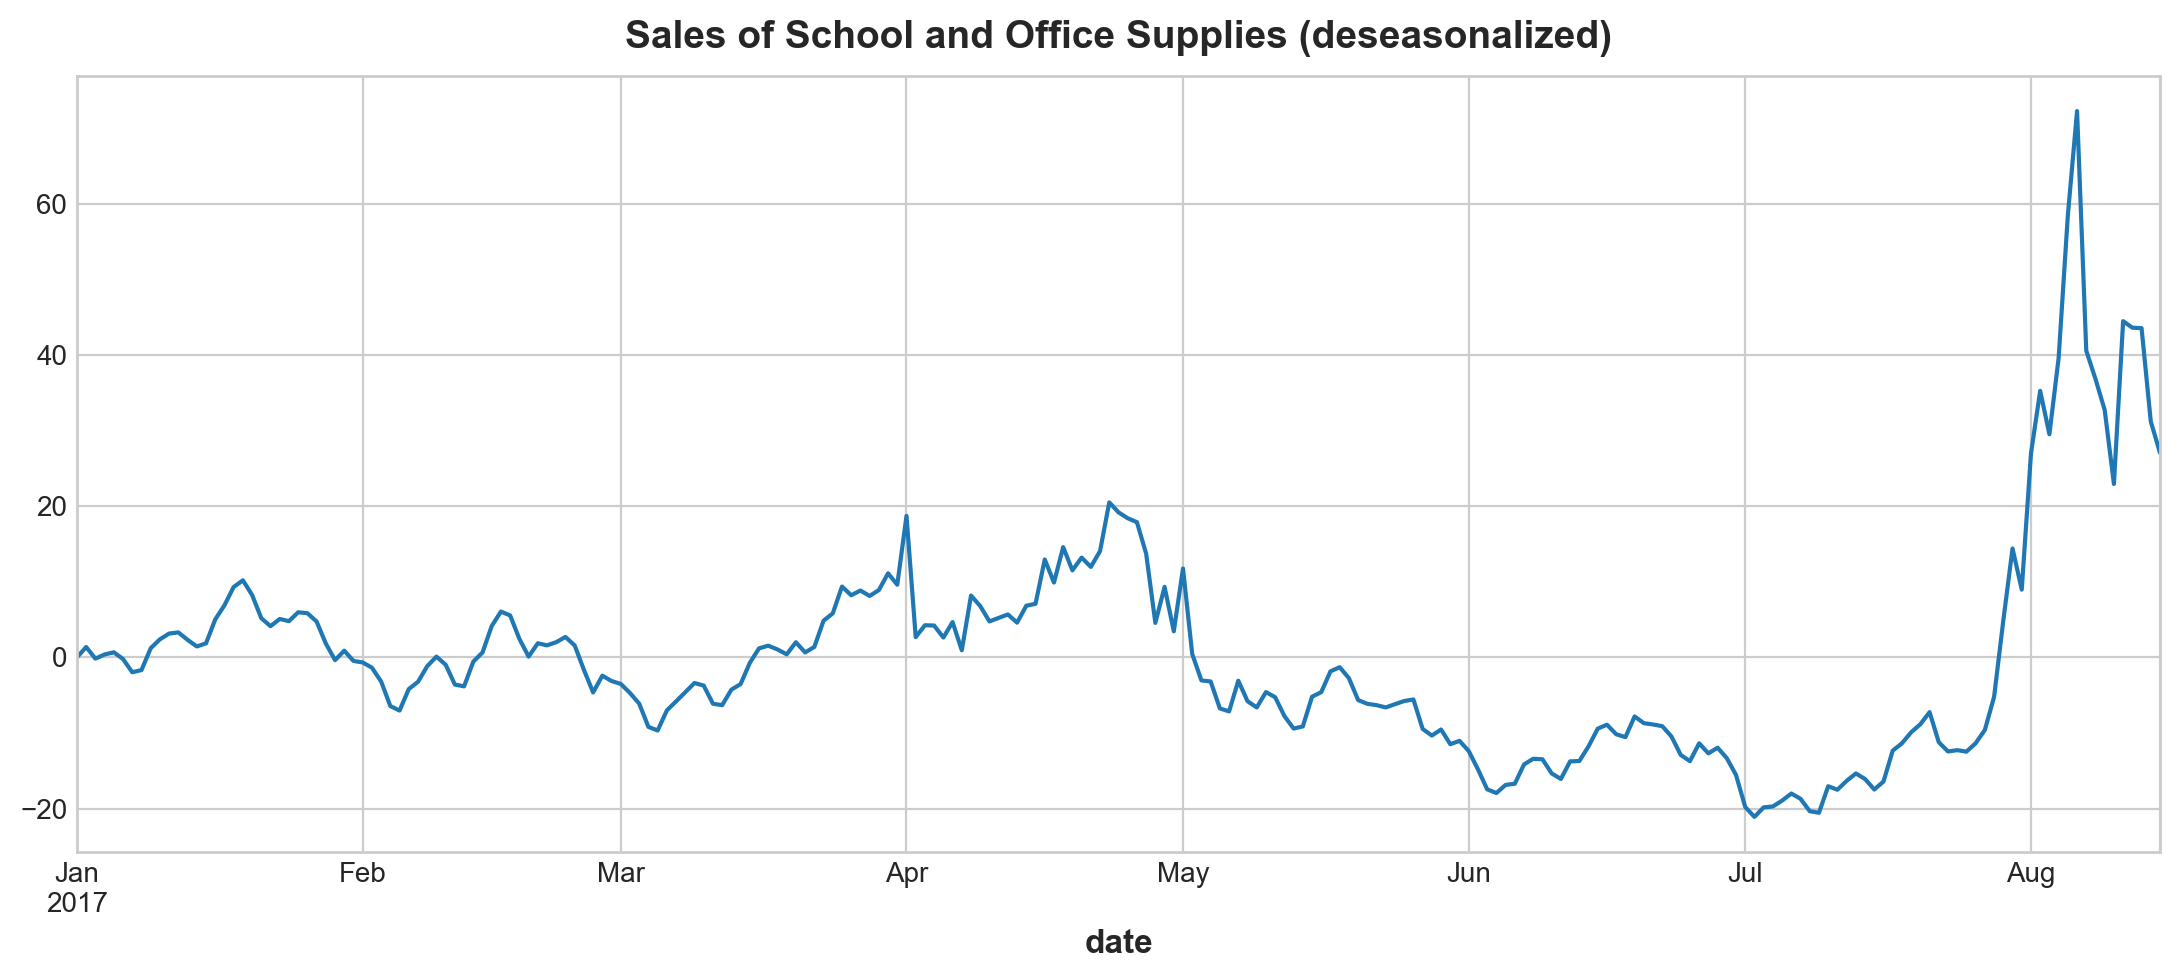

In [70]:
fourier = CalendarFourier(
    freq='M', order=4
)
dp = DeterministicProcess(
    index=y.index,
    order=1,
    constant=False,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X_time = dp.in_sample()
X_time['NewYearDay'] = (X.index.dayofyear == 1)

lr = LinearRegression()
lr.fit(X, y)
y_deseason = y - lr.predict(X)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)")

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.


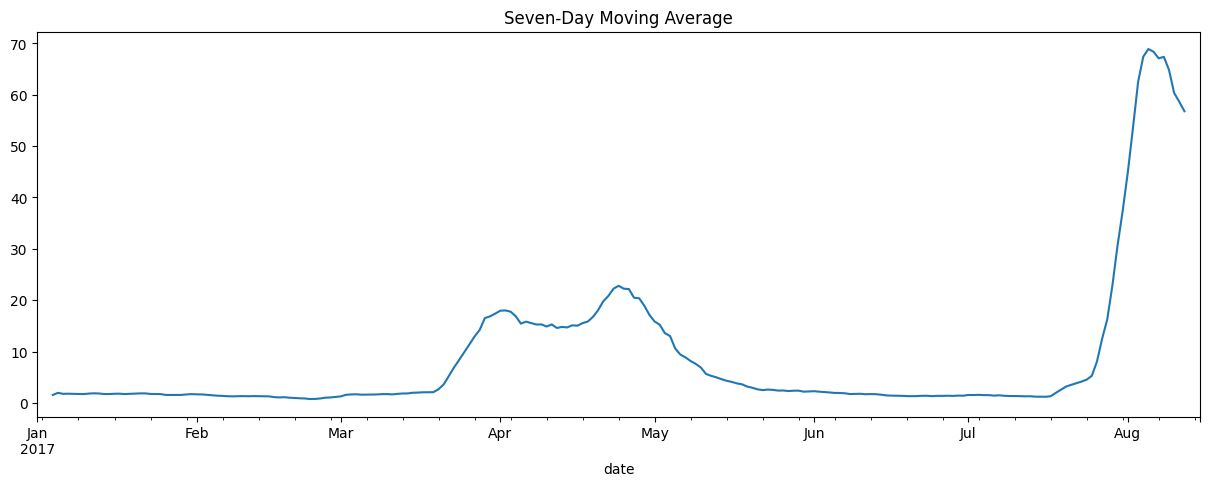

In [7]:
plt.figure(figsize=(15,5))
y_ma = y.rolling(
    window=7,
    center=True
).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");


We can see how the moving average plot resembles the plot of the deseasonalized series. In both, we can see cyclic behavior indicated.

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

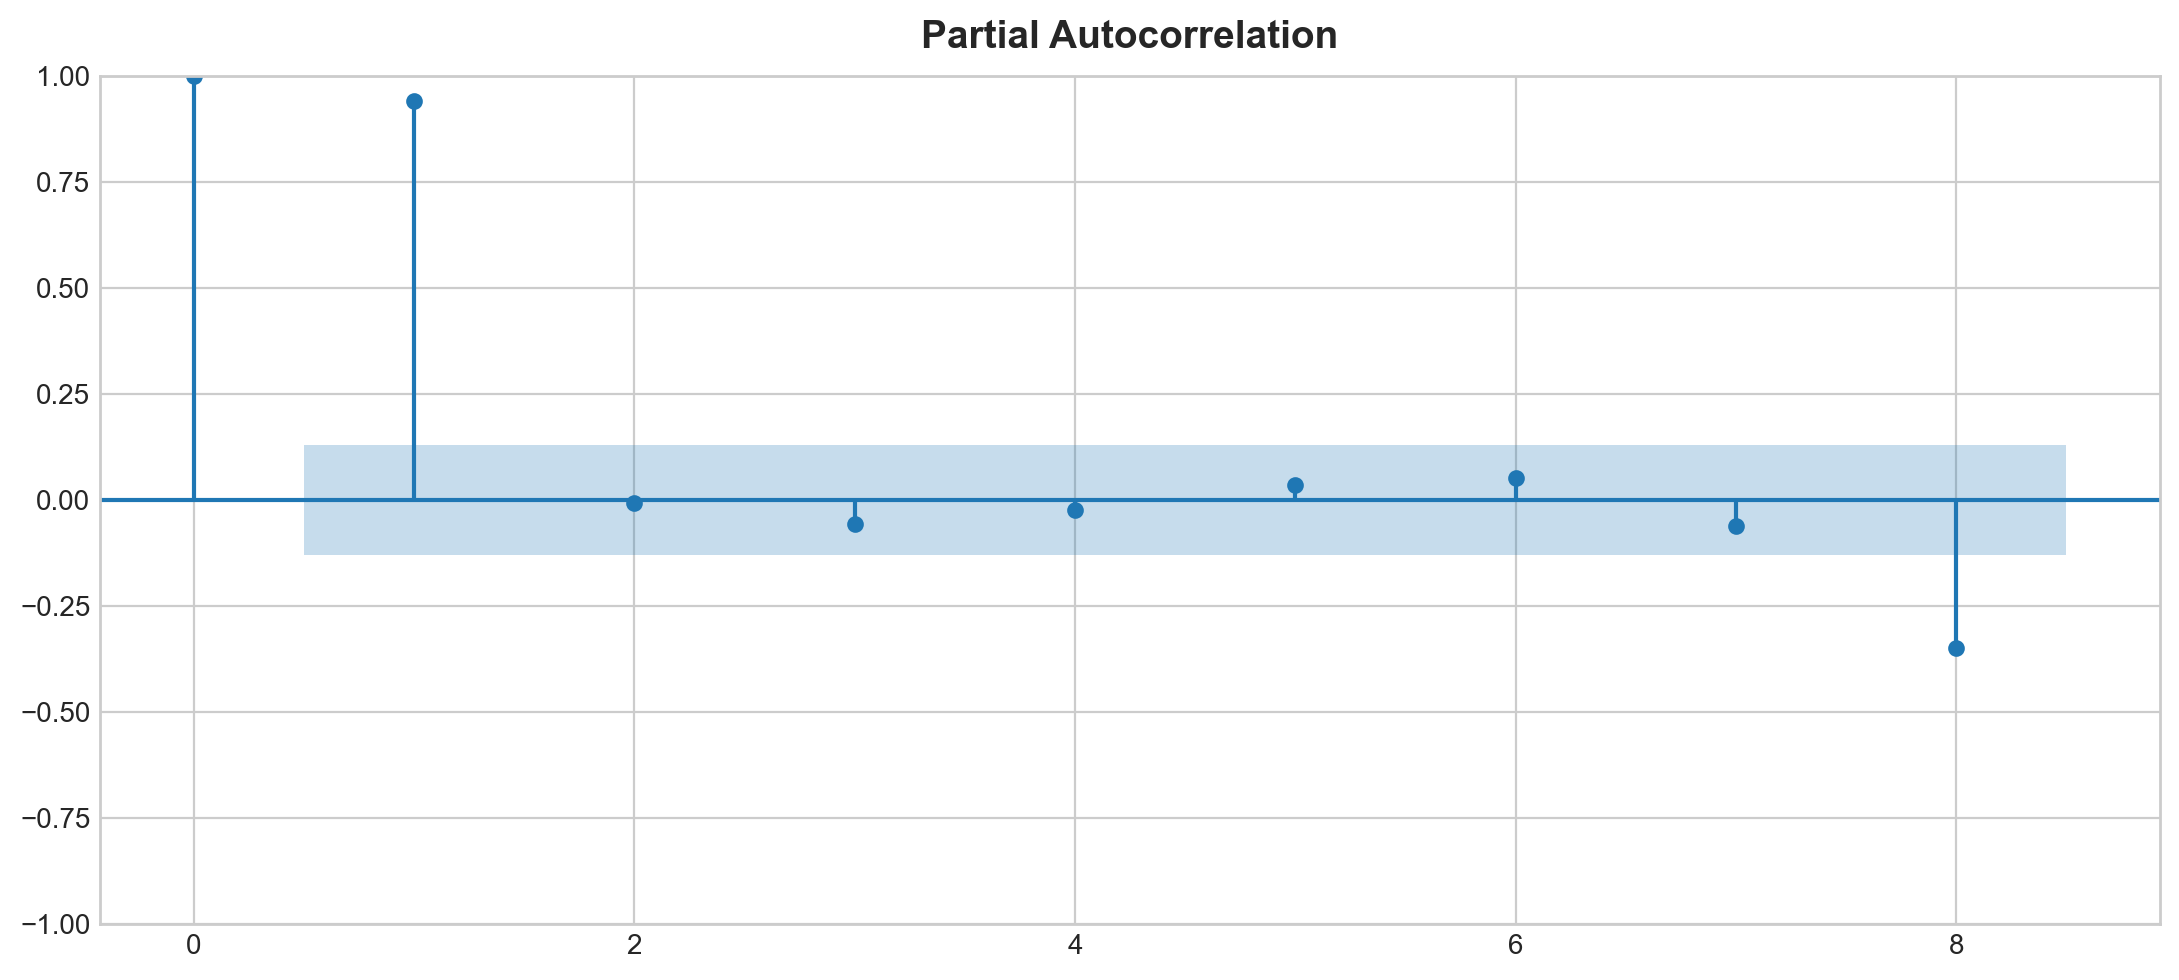

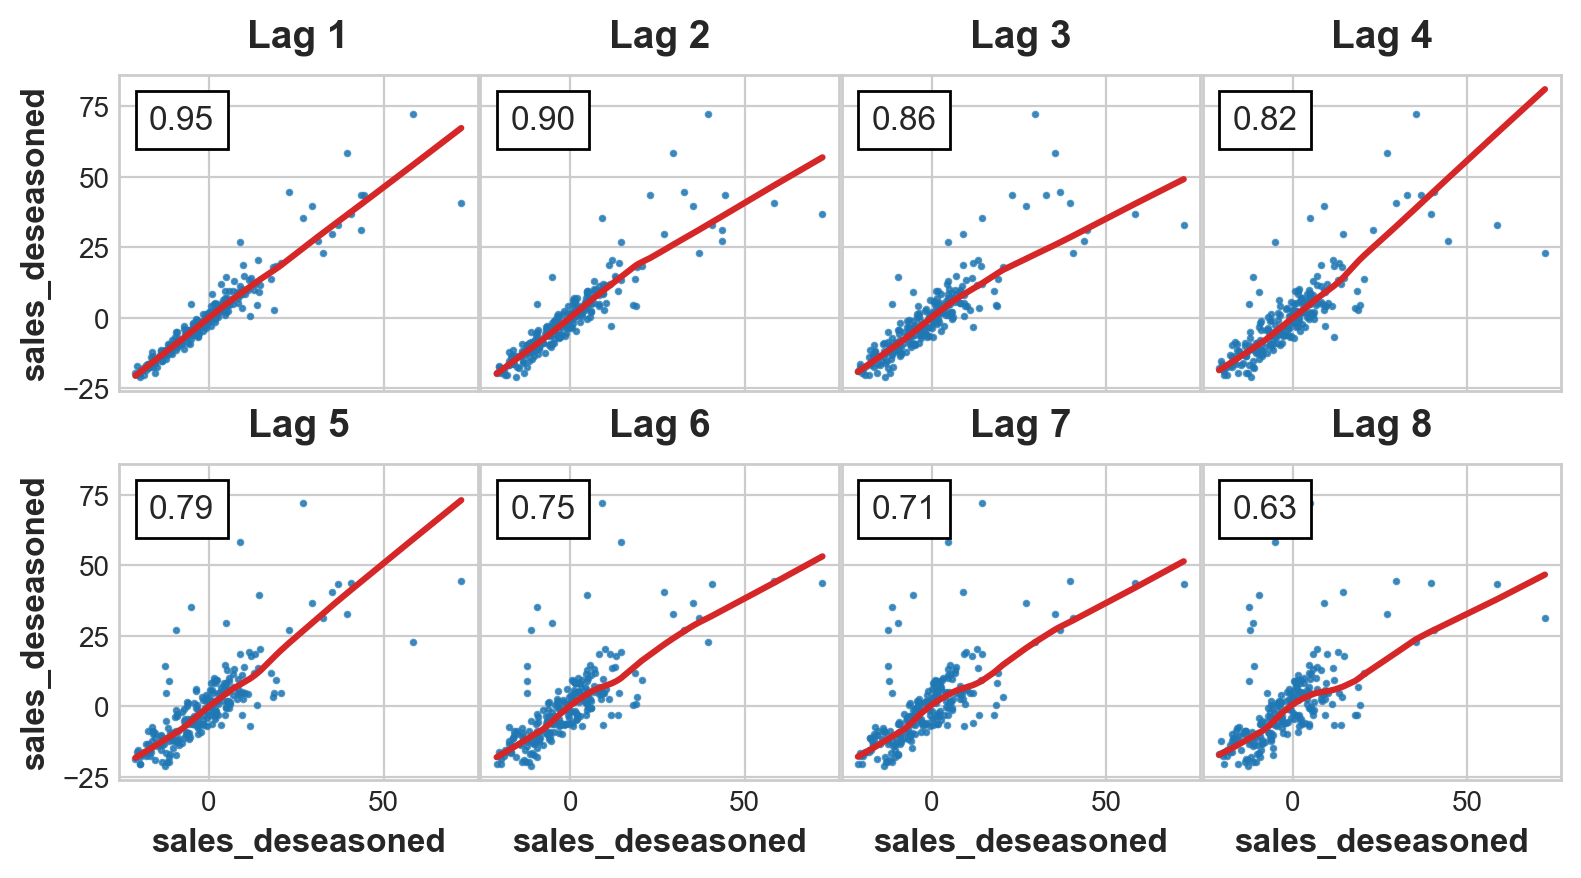

In [50]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.

A *leading indicator* is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The dataset includes a time series that could potentially be useful as a leading indicator -- the `onpromotion` series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's `onpromotion` value to forecast sales on Monday, for instance.

We will examine leading and lagging values for `onpromotion` plotted against sales of school and office supplies.

In [61]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
# plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

In [68]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)
def make_leads(ts, leads):
    return pd.concat(
        {
            f'y_lead_{i}': ts.shift(-i)
            for i in range(1, leads + 1)
        },
        axis=1)


In [72]:
X_lags = make_lags(y_deseason, lags=1)
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1)
], axis=1)
X = pd.concat([X_time, X_lags, X_promo], axis=1).fillna(0)
X.head()

trend  s(1,7)  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                        
2017-01-01    1.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    2.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    3.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    4.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    5.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=ME)  cos(1,freq=ME)  ...  cos(2,freq=ME)  \
date                                        ...                   
2017-01-01        0.000000        1.000000  ...        1.000000   
2017-01-02        0.201299        0.979530  ...        0.918958   
2017-01-03        0.394356        0.918958  ...        0.688967   
2017-01-04        0.571268        0.820763  ...        0.347305   
2017-01-05        0.724793        0.688967  ...       -0.050649   

            sin(3,freq=ME)  cos(3,freq=ME)  sin(4,freq=ME)  cos(4,freq=ME)  \
date                                                                         
2017-01-01        0.000000        1.000000        0.000000        1.000000   
2017-01-02        0.571268        0.820763        0.724793        0.688967   
2017-01-03        0.937752        0.347305        0.998717       -0.050649   
2017-01-04        0.968077       -0.250653        0.651372       -0.758758   
2017-01-05        0.651372       -0.758758       -0.101168       -0.994869   

            NewYearDay       y_lag_1  y_lag_1  onpromotion  y_lead_1  
date                                                                  
2017-01-01        True  0.000000e+00      0.0          0.0       0.0  
2017-01-02       False -1.731948e-14      0.0          0.0       0.0  
2017-01-03       False  1.362820e+00      0.0          0.0       0.0  
2017-01-04       False -1.724815e-01      0.0          0.0       0.0  
2017-01-05       False  3.777271e-01      0.0          0.0       0.0  

[5 rows x 21 columns]

Training RMSLE: 0.23846
Validation RMSLE: 0.35093


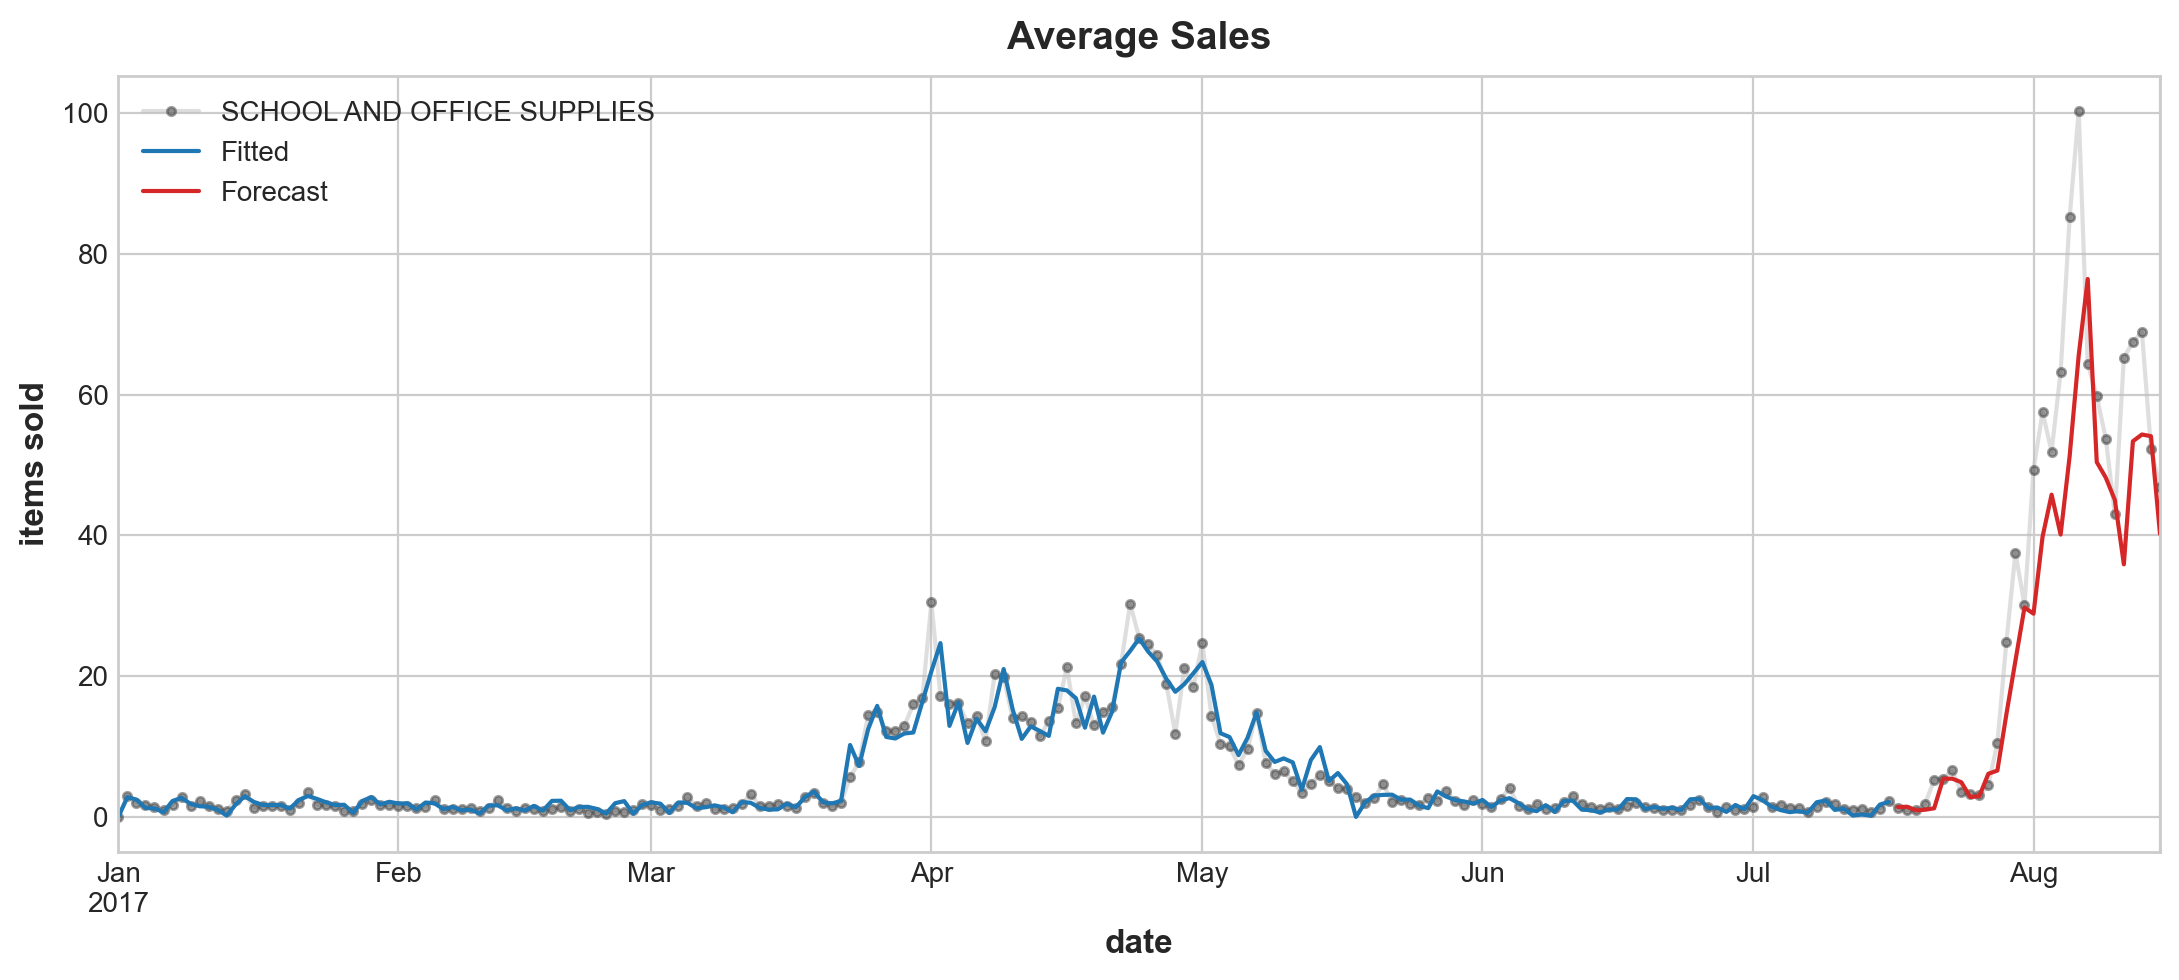

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend()